In [ ]:
# =========================
# 1. IMPORTS
# =========================
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Classical ML
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Ensemble
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    VotingClassifier,
    StackingClassifier
)

# Neural Network
from sklearn.neural_network import MLPClassifier

# XGBoost
from xgboost import XGBClassifier

# Imbalance
from imblearn.over_sampling import SMOTE

# =========================
# 2. LOAD DATA
# =========================
df = pd.read_csv("/content/cancer-risk-factors.csv")

# Drop non-essential columns
df.drop(columns=["Patient_ID", "Risk_Level"], inplace=True)

# Encode target
le = LabelEncoder()
df["Cancer_Type"] = le.fit_transform(df["Cancer_Type"])

X = df.drop(columns=["Cancer_Type"])
y = df["Cancer_Type"]

# =========================
# 3. TRAIN–TEST SPLIT
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# =========================
# 4. HANDLE IMBALANCE (SMOTE)
# =========================
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# =========================
# 5. FEATURE SCALING
# =========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# =========================
# 6. DEFINE ALL MODELS
# =========================
models = {

    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        multi_class="multinomial"
    ),

    "SVM": SVC(
        kernel="rbf",
        C=10,
        probability=True
    ),

    "KNN": KNeighborsClassifier(
        n_neighbors=7,
        weights="distance"
    ),

    "Decision Tree": DecisionTreeClassifier(
        max_depth=20,
        random_state=42
    ),

    "Gaussian NB": GaussianNB(),

    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        random_state=42
    ),

    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        random_state=42
    ),

    "AdaBoost": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=3),
        n_estimators=200,
        learning_rate=0.1,
        random_state=42
    ),

    "XGBoost": XGBClassifier(
        objective="multi:softprob",
        num_class=5,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="mlogloss",
        random_state=42
    ),

    "MLP": MLPClassifier(
        hidden_layer_sizes=(128, 64),
        max_iter=500,
        random_state=42
    )
}

# =========================
# 7. TRAIN & EVALUATE
# =========================
results = {}
trained_models = {}

for name, model in models.items():
    print(f"\n===== Training {name} =====")

    if name in ["Logistic Regression", "SVM", "KNN", "Gaussian NB", "MLP"]:
        model.fit(X_train_scaled, y_train_res)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    results[name] = {"Accuracy": acc, "Macro-F1": f1}
    trained_models[name] = model

    print(f"Accuracy  : {acc:.4f}")
    print(f"Macro-F1  : {f1:.4f}")

# =========================
# 8. VOTING CLASSIFIER
# =========================
voting = VotingClassifier(
    estimators=[
        ("rf", trained_models["Random Forest"]),
        ("xgb", trained_models["XGBoost"]),
        ("gb", trained_models["Gradient Boosting"])
    ],
    voting="soft"
)

voting.fit(X_train_scaled, y_train_res)
y_pred_vote = voting.predict(X_test_scaled)

results["Voting"] = {
    "Accuracy": accuracy_score(y_test, y_pred_vote),
    "Macro-F1": f1_score(y_test, y_pred_vote, average="macro")
}

# =========================
# 9. STACKING CLASSIFIER
# =========================
stacking = StackingClassifier(
    estimators=[
        ("rf", trained_models["Random Forest"]),
        ("xgb", trained_models["XGBoost"]),
        ("svm", trained_models["SVM"])
    ],
    final_estimator=LogisticRegression(max_iter=1000)
)

stacking.fit(X_train_scaled, y_train_res)
y_pred_stack = stacking.predict(X_test_scaled)

results["Stacking"] = {
    "Accuracy": accuracy_score(y_test, y_pred_stack),
    "Macro-F1": f1_score(y_test, y_pred_stack, average="macro")
}

# =========================
# 10. FINAL RESULTS TABLE
# =========================
results_df = pd.DataFrame(results).T.sort_values("Macro-F1", ascending=False)
print("\n===== FINAL MODEL COMPARISON =====")
print(results_df)

best_model_name = results_df.index[0]
print("\nBest Model:", best_model_name)

# =========================
# 11. CLASSIFICATION REPORT
# =========================
best_model = trained_models.get(best_model_name, None)

if best_model_name in ["Logistic Regression", "SVM", "KNN", "Gaussian NB", "MLP"]:
    y_best = best_model.predict(X_test_scaled)
else:
    y_best = best_model.predict(X_test)

print("\n===== CLASSIFICATION REPORT =====")
print(classification_report(
    y_test,
    y_best,
    target_names=le.classes_
))



===== Training Logistic Regression =====
Accuracy  : 0.7425
Macro-F1  : 0.7267

===== Training SVM =====
Accuracy  : 0.6850
Macro-F1  : 0.6748

===== Training KNN =====
Accuracy  : 0.6250
Macro-F1  : 0.6025

===== Training Decision Tree =====
Accuracy  : 0.6000
Macro-F1  : 0.5875

===== Training Gaussian NB =====
Accuracy  : 0.5175
Macro-F1  : 0.4972

===== Training Random Forest =====
Accuracy  : 0.7725
Macro-F1  : 0.7536

===== Training Gradient Boosting =====
Accuracy  : 0.7600
Macro-F1  : 0.7467

===== Training AdaBoost =====
Accuracy  : 0.7325
Macro-F1  : 0.7237

===== Training XGBoost =====
Accuracy  : 0.7725
Macro-F1  : 0.7620

===== Training MLP =====
Accuracy  : 0.7200
Macro-F1  : 0.6983

===== FINAL MODEL COMPARISON =====
                     Accuracy  Macro-F1
XGBoost                0.7725  0.762033
Voting                 0.7725  0.760893
Stacking               0.7700  0.756925
Random Forest          0.7725  0.753568
Gradient Boosting      0.7600  0.746665
Logistic Regressi

In [ ]:
# =========================
# 1. IMPORTS
# =========================
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Classical ML
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Ensemble
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    VotingClassifier,
    StackingClassifier
)

# Neural Network
from sklearn.neural_network import MLPClassifier

# XGBoost
from xgboost import XGBClassifier

# Imbalance
from imblearn.over_sampling import SMOTE

# =========================
# 2. LOAD DATA
# =========================
df = pd.read_csv("/content/cancer-risk-factors.csv")

# Drop non-essential columns
df.drop(columns=["Patient_ID", "Risk_Level"], inplace=True)

# =========================
# 3. HANDLE CATEGORICAL VARIABLES
# =========================
# Encode target
le_target = LabelEncoder()
df["Cancer_Type"] = le_target.fit_transform(df["Cancer_Type"])

# Encode any other categorical columns if present
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le_col = LabelEncoder()
    df[col] = le_col.fit_transform(df[col])

# =========================
# 4. FEATURES & TARGET
# =========================
X = df.drop(columns=["Cancer_Type"])
y = df["Cancer_Type"]

# =========================
# 5. TRAIN–TEST SPLIT
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# =========================
# 6. HANDLE IMBALANCE (SMOTE)
# =========================
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# =========================
# 7. FEATURE SCALING
# =========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# =========================
# 8. DEFINE MODELS
# =========================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class="multinomial"),
    "SVM": SVC(kernel="rbf", C=10, probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=7, weights="distance"),
    "Decision Tree": DecisionTreeClassifier(max_depth=20, random_state=42),
    "Gaussian NB": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42),
    "AdaBoost": AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=200, learning_rate=0.1, random_state=42),
    "XGBoost": XGBClassifier(objective="multi:softprob", num_class=5, n_estimators=300, learning_rate=0.05,
                             max_depth=6, subsample=0.9, colsample_bytree=0.9, eval_metric="mlogloss", random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=500, random_state=42)
}

# =========================
# 9. TRAIN & EVALUATE MODELS
# =========================
results = {}
trained_models = {}

for name, model in models.items():
    print(f"\n===== Training {name} =====")

    if name in ["Logistic Regression", "SVM", "KNN", "Gaussian NB", "MLP"]:
        model.fit(X_train_scaled, y_train_res)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    results[name] = {"Accuracy": acc, "Macro-F1": f1}
    trained_models[name] = model

    print(f"Accuracy  : {acc:.4f}")
    print(f"Macro-F1  : {f1:.4f}")

# =========================
# 10. VOTING CLASSIFIER
# =========================
voting = VotingClassifier(
    estimators=[
        ("rf", trained_models["Random Forest"]),
        ("xgb", trained_models["XGBoost"]),
        ("gb", trained_models["Gradient Boosting"])
    ],
    voting="soft"
)
voting.fit(X_train_scaled, y_train_res)
y_pred_vote = voting.predict(X_test_scaled)

results["Voting"] = {
    "Accuracy": accuracy_score(y_test, y_pred_vote),
    "Macro-F1": f1_score(y_test, y_pred_vote, average="macro")
}

# =========================
# 11. STACKING CLASSIFIER
# =========================
stacking = StackingClassifier(
    estimators=[
        ("rf", trained_models["Random Forest"]),
        ("xgb", trained_models["XGBoost"]),
        ("svm", trained_models["SVM"])
    ],
    final_estimator=LogisticRegression(max_iter=1000)
)
stacking.fit(X_train_scaled, y_train_res)
y_pred_stack = stacking.predict(X_test_scaled)

results["Stacking"] = {
    "Accuracy": accuracy_score(y_test, y_pred_stack),
    "Macro-F1": f1_score(y_test, y_pred_stack, average="macro")
}

# =========================
# 12. RESULTS TABLE
# =========================
results_df = pd.DataFrame(results).T.sort_values("Macro-F1", ascending=False)
print("\n===== FINAL MODEL COMPARISON =====")
print(results_df)

best_model_name = results_df.index[0]
print("\nBest Model:", best_model_name)

# =========================
# 13. CLASSIFICATION REPORT
# =========================
best_model = trained_models.get(best_model_name)
if best_model_name in ["Logistic Regression", "SVM", "KNN", "Gaussian NB", "MLP"]:
    y_best = best_model.predict(X_test_scaled)
else:
    y_best = best_model.predict(X_test)

print("\n===== CLASSIFICATION REPORT =====")
print(classification_report(
    y_test,
    y_best,
    target_names=le_target.classes_
))



===== Training Logistic Regression =====
Accuracy  : 0.7425
Macro-F1  : 0.7267

===== Training SVM =====
Accuracy  : 0.6850
Macro-F1  : 0.6748

===== Training KNN =====
Accuracy  : 0.6250
Macro-F1  : 0.6025

===== Training Decision Tree =====
Accuracy  : 0.6000
Macro-F1  : 0.5875

===== Training Gaussian NB =====
Accuracy  : 0.5175
Macro-F1  : 0.4972

===== Training Random Forest =====
Accuracy  : 0.7725
Macro-F1  : 0.7536

===== Training Gradient Boosting =====
Accuracy  : 0.7600
Macro-F1  : 0.7467

===== Training AdaBoost =====
Accuracy  : 0.7325
Macro-F1  : 0.7237

===== Training XGBoost =====
Accuracy  : 0.7725
Macro-F1  : 0.7620

===== Training MLP =====
Accuracy  : 0.7200
Macro-F1  : 0.6983

===== FINAL MODEL COMPARISON =====
                     Accuracy  Macro-F1
XGBoost                0.7725  0.762033
Voting                 0.7725  0.760893
Stacking               0.7700  0.756925
Random Forest          0.7725  0.753568
Gradient Boosting      0.7600  0.746665
Logistic Regressi

In [ ]:
# =========================
# 1. IMPORTS & SETUP
# =========================
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek # Better than standard SMOTE

warnings.filterwarnings("ignore")

# =========================
# 2. LOAD & PREPROCESS
# =========================
df = pd.read_csv("/content/cancer-risk-factors.csv")
df.drop(columns=["Patient_ID", "Risk_Level"], inplace=True, errors='ignore')

# Encode Target
le_target = LabelEncoder()
df["Cancer_Type"] = le_target.fit_transform(df["Cancer_Type"])

# Encode Categorical Features
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Split Features/Target
X = df.drop(columns=["Cancer_Type"])
y = df["Cancer_Type"]

# =========================
# 3. TRAIN–TEST SPLIT & RESAMPLING
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# SMOTETomek removes overlapping samples after oversampling for cleaner boundaries
smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

# Scaling (Only for models that need it like SVM/Logistic)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# =========================
# 4. HYPERPARAMETER TUNING (XGBoost)
# =========================
# Instead of guessing parameters, we search for the best ones
print("--- Tuning XGBoost for Maximum Accuracy ---")
xgb_params = {
    'n_estimators': [200, 500, 800],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

rs_xgb = RandomizedSearchCV(
    XGBClassifier(eval_metric="mlogloss"),
    param_distributions=xgb_params,
    n_iter=10,
    cv=3,
    random_state=42,
    n_jobs=-1
)
rs_xgb.fit(X_train_res, y_train_res)
best_xgb = rs_xgb.best_estimator_

# =========================
# 5. ADVANCED STACKING ENSEMBLE
# =========================
# Combining different "brains" into one meta-model
print("--- Training Stacking Ensemble ---")
base_models = [
    ('rf', RandomForestClassifier(n_estimators=500, random_state=42)),
    ('xgb', best_xgb),
    ('svc', SVC(probability=True, kernel='rbf', C=10))
]

# Using Logistic Regression as the 'Final Judge'
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    cv=5
)

# Note: Using scaled data for stacking because of SVC
stacking_model.fit(X_train_scaled, y_train_res)

# =========================
# 6. EVALUATION
# =========================
models_to_test = {
    "Tuned XGBoost": (best_xgb, X_test),
    "Stacking Ensemble": (stacking_model, X_test_scaled)
}

results = {}
for name, (model, data) in models_to_test.items():
    y_pred = model.predict(data)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    results[name] = {"Accuracy": acc, "Macro-F1": f1}

# Display Results
results_df = pd.DataFrame(results).T
print("\n===== IMPROVED RESULTS =====")
print(results_df)

# Final Detailed Report
best_model_key = results_df['Accuracy'].idxmax()
final_model = models_to_test[best_model_key][0]
final_data = models_to_test[best_model_key][1]

print(f"\n===== FINAL REPORT: {best_model_key} =====")
print(classification_report(y_test, final_model.predict(final_data), target_names=le_target.classes_))

--- Tuning XGBoost for Maximum Accuracy ---
--- Training Stacking Ensemble ---

===== IMPROVED RESULTS =====
                   Accuracy  Macro-F1
Tuned XGBoost         0.780  0.771194
Stacking Ensemble     0.775  0.766266

===== FINAL REPORT: Tuned XGBoost =====
              precision    recall  f1-score   support

      Breast       0.86      0.68      0.76        92
       Colon       0.74      0.80      0.77        84
        Lung       0.84      0.88      0.86       105
    Prostate       0.80      0.79      0.79        61
        Skin       0.64      0.72      0.68        58

    accuracy                           0.78       400
   macro avg       0.77      0.77      0.77       400
weighted avg       0.79      0.78      0.78       400



In [ ]:
pip install lazypredict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.7/774.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek

# !pip install lazypredict
from lazypredict.Supervised import LazyClassifier

# ======================================================
# 1. LOAD & PREPROCESS (Optimized for LazyPredict)
# ======================================================
dataset_path = "/content/cancer-risk-factors.csv"
df = pd.read_csv(dataset_path)

# Drop non-essential
df.drop(columns=["Patient_ID", "Risk_Level"], inplace=True, errors='ignore')

# Encode Target
le_target = LabelEncoder()
df["Cancer_Type"] = le_target.fit_transform(df["Cancer_Type"])

# Encode categorical features
cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=["Cancer_Type"])
y = df["Cancer_Type"]

# Impute missing values
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Handle Imbalance with SMOTETomek (Cleaner than standard SMOTE)
smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

# ======================================================
# 2. LAZY PREDICT - The "Model Tournament"
# ======================================================
print("\n--- Running LazyPredict Tournament ---")

# We initialize LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit all models at once
models, predictions = clf.fit(X_train_res, X_test, y_train_res, y_test)

# ======================================================
# 3. DISPLAY RESULTS
# ======================================================
print("\n===== ALL MODELS RANKED BY ACCURACY =====")
print(models)

# To find your best candidate for the 5% boost:
top_model = models.index[0]
print(f"\nRecommended Model to Tune: {top_model}")


--- Running LazyPredict Tournament ---


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3729
[LightGBM] [Info] Number of data points in the train set: 1984, number of used features: 18
[LightGBM] [Info] Start training from score -1.619061
[LightGBM] [Info] Start training from score -1.611456
[LightGBM] [Info] Start training from score -1.642228
[LightGBM] [Info] Start training from score -1.586517
[LightGBM] [Info] Start training from score -1.588983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

===== ALL MODELS RANKED BY ACCURACY =====
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
RandomForestClassifier             0.79               0.77    None      0.78   
XGBClassifier                      0.76               0.75    None      0.76   
Extr

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define a more aggressive search grid
param_grid = {
    'n_estimators': [300, 500, 800],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)

# Use GridSearchCV to find the version that beats the LazyPredict default
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_res, y_train_res)

print("Best Parameters:", grid_search.best_params_)
print("Improved Accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Improved Accuracy: 0.8493234791802831


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# ======================================================
# 1. LOAD & PREPROCESS (Optimized for LazyPredict)
# ======================================================
dataset_path = "/content/cancer-risk-factors.csv"
df = pd.read_csv(dataset_path)

# Drop non-essential columns
df.drop(columns=["Patient_ID", "Risk_Level"], inplace=True, errors='ignore')

# Encode Target
le_target = LabelEncoder()
df["Cancer_Type"] = le_target.fit_transform(df["Cancer_Type"])

# Encode categorical features
cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=["Cancer_Type"])
y = df["Cancer_Type"]

# Impute missing values
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Handle Imbalance with SMOTETomek (Cleaner than standard SMOTE)
smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

# ======================================================
# 2. HYPERPARAMETER TUNING USING GRIDSEARCHCV
# ======================================================

# Define the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [300, 500, 800],               # Number of trees in the forest
    'max_depth': [10, 20, None],                   # Maximum depth of each tree
    'min_samples_split': [2, 5],                   # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2],                    # Minimum samples required to be at a leaf node
    'max_features': ['sqrt', 'log2']               # The number of features to consider when looking for the best split
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train_res, y_train_res)

# ======================================================
# 3. DISPLAY BEST PARAMETERS AND SCORE
# ======================================================

# Best parameters and score from GridSearchCV
print("Best Parameters:", grid_search.best_params_)
print("Improved Accuracy:", grid_search.best_score_)

# ======================================================
# 4. EVALUATE THE MODEL ON TEST DATA
# ======================================================

# Predict on the test set using the best estimator found by GridSearchCV
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate Precision, Recall, and F1-Score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Display classification report (Precision, Recall, F1-Score for each class)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display Precision, Recall, and F1-Score
print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Improved Accuracy: 0.8493234791802831

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.77      0.80        92
           1       0.78      0.74      0.76        84
           2       0.81      0.90      0.86       105
           3       0.73      0.80      0.77        61
           4       0.65      0.59      0.62        58

    accuracy                           0.78       400
   macro avg       0.76      0.76      0.76       400
weighted avg       0.78      0.78      0.78       400


Precision: 0.7764
Recall: 0.7775
F1-Score: 0.7753


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score
import xgboost as xgb

# ======================================================
# 1. LOAD & PREPROCESS (Optimized for LazyPredict)
# ======================================================
dataset_path = "/content/cancer-risk-factors.csv"
df = pd.read_csv(dataset_path)

# Drop non-essential columns
df.drop(columns=["Patient_ID", "Risk_Level"], inplace=True, errors='ignore')

# Encode Target
le_target = LabelEncoder()
df["Cancer_Type"] = le_target.fit_transform(df["Cancer_Type"])

# Encode categorical features
cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=["Cancer_Type"])
y = df["Cancer_Type"]

# Impute missing values
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Handle Imbalance with SMOTETomek (Cleaner than standard SMOTE)
smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

# ======================================================
# 2. ADDITIONAL MODELS AND HYPERPARAMETER TUNING USING GRIDSEARCHCV
# ======================================================

# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

# Define parameter grids for each model
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10]
    },
    "Random Forest": {
        'n_estimators': [300, 500, 800],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    },
    "XGBoost": {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    "Decision Tree": {
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "AdaBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1]
    }
}

# Initialize the results storage
results = {}

# GridSearchCV to find the best parameters for each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Get the corresponding parameter grid
    param_grid = param_grids[model_name]

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

    # Fit the model
    grid_search.fit(X_train_res, y_train_res)

    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Predict on the test set
    y_pred = best_model.predict(X_test)

    # Calculate Precision, Recall, and F1-Score
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Calculate Accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Get the "Improved Accuracy" (from GridSearchCV on the training set)
    improved_accuracy = grid_search.best_score_

    # Store the results
    results[model_name] = {
        'Best Parameters': grid_search.best_params_,
        'Improved Accuracy': improved_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Test Accuracy': accuracy
    }

    # Display classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

    print(f"\n{model_name} - Precision: {precision:.4f}")
    print(f"{model_name} - Recall: {recall:.4f}")
    print(f"{model_name} - F1-Score: {f1:.4f}")
    print(f"{model_name} - Test Accuracy: {accuracy:.4f}")
    print(f"{model_name} - Improved Accuracy (from GridSearchCV): {improved_accuracy:.4f}")
    print(f"{model_name} - Best Parameters: {grid_search.best_params_}")

# ======================================================
# 3. DISPLAY RESULTS FOR ALL MODELS
# ======================================================

# Convert results to a DataFrame
results_df = pd.DataFrame(results).T
import caas_jupyter_tools as tools; tools.display_dataframe_to_user(name="Model Comparison Results", dataframe=results_df)

print("\n===== All Models Results =====")
print(results_df)



Training Logistic Regression...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77        92
           1       0.75      0.70      0.72        84
           2       0.85      0.85      0.85       105
           3       0.67      0.75      0.71        61
           4       0.53      0.59      0.56        58

    accuracy                           0.74       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.74      0.74      0.74       400


Logistic Regression - Precision: 0.7437
Logistic Regression - Recall: 0.7375
Logistic Regression - F1-Score: 0.7394
Logistic Regression - Test Accuracy: 0.7375
Logistic Regression - Improved Accuracy (from GridSearchCV): 0.7687
Logistic Regression - Best Parameters: {'C': 10}

Training Random Forest...
Fitting 3 folds for each of 72 candidates, totalling 216 fits

Random

ModuleNotFoundError: No module named 'caas_jupyter_tools'

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek

# !pip install lazypredict
from lazypredict.Supervised import LazyClassifier

# ======================================================
# 1. LOAD & PREPROCESS (Optimized for LazyPredict)
# ======================================================
dataset_path = "/content/cancer-risk-factors.csv"
df = pd.read_csv(dataset_path)

# Drop non-essential
df.drop(columns=["Patient_ID", "Risk_Level"], inplace=True, errors='ignore')

# Encode Target
le_target = LabelEncoder()
df["Cancer_Type"] = le_target.fit_transform(df["Cancer_Type"])

# Encode categorical features
cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=["Cancer_Type"])
y = df["Cancer_Type"]

# Impute missing values
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Handle Imbalance with SMOTETomek (Cleaner than standard SMOTE)
smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

# ======================================================
# 2. LAZY PREDICT - The "Model Tournament"
# ======================================================
print("\n--- Running LazyPredict Tournament ---")

# We initialize LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit all models at once
models, predictions = clf.fit(X_train_res, X_test, y_train_res, y_test)

# ======================================================
# 3. DISPLAY RESULTS INCLUDING PRECISION, RECALL, F1-SCORE
# ======================================================
print("\n===== ALL MODELS RANKED BY ACCURACY =====")
print(models)

# Inspect columns to ensure we're accessing the correct ones
print("\nColumns in models DataFrame:")
print(models.columns)

# Extract relevant metrics only if they exist
if 'Precision' in models.columns and 'Recall' in models.columns and 'F1 Score' in models.columns:
    metrics = models[['Precision', 'Recall', 'F1 Score']]
else:
    # Display columns to understand the structure
    print("Column names might be different. Check column names and adjust accordingly.")
    print(models.head())  # Display the first few rows of the dataframe to inspect columns
    metrics = models[['precision_score', 'recall_score', 'f1_score']]  # Adjust if needed

print("\n===== PRECISION, RECALL, AND F1-SCORE FOR EACH MODEL =====")
print(metrics)

# To find your best candidate for the 5% boost:
top_model = models.index[0]
print(f"\nRecommended Model to Tune: {top_model}")



--- Running LazyPredict Tournament ---


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3729
[LightGBM] [Info] Number of data points in the train set: 1984, number of used features: 18
[LightGBM] [Info] Start training from score -1.619061
[LightGBM] [Info] Start training from score -1.611456
[LightGBM] [Info] Start training from score -1.642228
[LightGBM] [Info] Start training from score -1.586517
[LightGBM] [Info] Start training from score -1.588983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

===== ALL MODELS RANKED BY ACCURACY =====
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
RandomForestClassifier             0.79               0.77    None      0.78   
XGBClassifier                      0.76               0.75    None      0.76   
Extr

KeyError: "None of [Index(['precision_score', 'recall_score', 'f1_score'], dtype='object')] are in the [columns]"

In [ ]:
print(models.columns)


Index(['Accuracy', 'Balanced Accuracy', 'ROC AUC', 'F1 Score', 'Time Taken'], dtype='object')


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek

# !pip install lazypredict
from lazypredict.Supervised import LazyClassifier

# ======================================================
# 1. LOAD & PREPROCESS (Optimized for LazyPredict)
# ======================================================
dataset_path = "/content/cancer-risk-factors.csv"
df = pd.read_csv(dataset_path)

# Drop non-essential
df.drop(columns=["Patient_ID", "Risk_Level"], inplace=True, errors='ignore')

# Encode Target
le_target = LabelEncoder()
df["Cancer_Type"] = le_target.fit_transform(df["Cancer_Type"])

# Encode categorical features
cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=["Cancer_Type"])
y = df["Cancer_Type"]

# Impute missing values
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Handle Imbalance with SMOTETomek (Cleaner than standard SMOTE)
smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

# ======================================================
# 2. LAZY PREDICT - The "Model Tournament"
# ======================================================
print("\n--- Running LazyPredict Tournament ---")

# We initialize LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit all models at once
models, predictions = clf.fit(X_train_res, X_test, y_train_res, y_test)

# ======================================================
# 3. DISPLAY RESULTS INCLUDING F1-SCORE, ACCURACY, ROC AUC
# ======================================================
print("\n===== ALL MODELS RANKED BY ACCURACY =====")
print(models)

# Extract relevant metrics (Accuracy, F1 Score, ROC AUC)
metrics = models[['Accuracy', 'F1 Score', 'ROC AUC']]

print("\n===== ACCURACY, F1-SCORE, AND ROC AUC FOR EACH MODEL =====")
print(metrics)

# To find your best candidate for the 5% boost:
top_model = models.index[0]
print(f"\nRecommended Model to Tune: {top_model}")



--- Running LazyPredict Tournament ---


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3729
[LightGBM] [Info] Number of data points in the train set: 1984, number of used features: 18
[LightGBM] [Info] Start training from score -1.619061
[LightGBM] [Info] Start training from score -1.611456
[LightGBM] [Info] Start training from score -1.642228
[LightGBM] [Info] Start training from score -1.586517
[LightGBM] [Info] Start training from score -1.588983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

===== ALL MODELS RANKED BY ACCURACY =====
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
RandomForestClassifier             0.79               0.77    None      0.78   
XGBClassifier       

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score
import xgboost as xgb

# ======================================================
# 1. LOAD & PREPROCESS (Optimized for LazyPredict)
# ======================================================
dataset_path = "/content/cancer-risk-factors.csv"
df = pd.read_csv(dataset_path)

# Drop non-essential columns
df.drop(columns=["Patient_ID", "Risk_Level"], inplace=True, errors='ignore')

# Encode Target
le_target = LabelEncoder()
df["Cancer_Type"] = le_target.fit_transform(df["Cancer_Type"])

# Encode categorical features
cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=["Cancer_Type"])
y = df["Cancer_Type"]

# Impute missing values
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Handle Imbalance with SMOTETomek (Cleaner than standard SMOTE)
smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

# ======================================================
# 2. ADDITIONAL MODELS AND HYPERPARAMETER TUNING USING GRIDSEARCHCV
# ======================================================

# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

# Define parameter grids for each model
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10]
    },
    "Random Forest": {
        'n_estimators': [300, 500, 800],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    },
    "XGBoost": {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    "Decision Tree": {
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "AdaBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1]
    }
}

# Initialize the results storage
results = {}

# GridSearchCV to find the best parameters for each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Get the corresponding parameter grid
    param_grid = param_grids[model_name]

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

    # Fit the model
    grid_search.fit(X_train_res, y_train_res)

    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Predict on the test set
    y_pred_test = best_model.predict(X_test)

    # Calculate Precision, Recall, and F1-Score for test set
    precision_test = precision_score(y_test, y_pred_test, average='weighted')
    recall_test = recall_score(y_test, y_pred_test, average='weighted')
    f1_test = f1_score(y_test, y_pred_test, average='weighted')

    # Calculate Accuracy for test set
    accuracy_test = accuracy_score(y_test, y_pred_test)

    # Get the "Improved Accuracy" (from GridSearchCV on the training set)
    improved_accuracy = grid_search.best_score_

    # Predict on the training set for improved metrics
    y_pred_train = best_model.predict(X_train_res)

    # Calculate Precision, Recall, and F1-Score for the training set (improved metrics)
    precision_train = precision_score(y_train_res, y_pred_train, average='weighted')
    recall_train = recall_score(y_train_res, y_pred_train, average='weighted')
    f1_train = f1_score(y_train_res, y_pred_train, average='weighted')

    # Store the results
    results[model_name] = {
        'Best Parameters': grid_search.best_params_,
        'Improved Accuracy': improved_accuracy,
        'Precision (Train)': precision_train,
        'Recall (Train)': recall_train,
        'F1-Score (Train)': f1_train,
        'Test Accuracy': accuracy_test,
        'Precision (Test)': precision_test,
        'Recall (Test)': recall_test,
        'F1-Score (Test)': f1_test
    }

    # Display classification report for test set
    print(f"\n{model_name} Classification Report (Test Set):")
    print(classification_report(y_test, y_pred_test))

    print(f"\n{model_name} - Precision (Test): {precision_test:.4f}")
    print(f"{model_name} - Recall (Test): {recall_test:.4f}")
    print(f"{model_name} - F1-Score (Test): {f1_test:.4f}")
    print(f"{model_name} - Test Accuracy: {accuracy_test:.4f}")
    print(f"{model_name} - Precision (Train): {precision_train:.4f}")
    print(f"{model_name} - Recall (Train): {recall_train:.4f}")
    print(f"{model_name} - F1-Score (Train): {f1_train:.4f}")
    print(f"{model_name} - Improved Accuracy (from GridSearchCV): {improved_accuracy:.4f}")
    print(f"{model_name} - Best Parameters: {grid_search.best_params_}")

# ======================================================
# 3. DISPLAY RESULTS FOR ALL MODELS
# ======================================================

# Convert results to a DataFrame
results_df = pd.DataFrame(results).T
import caas_jupyter_tools as tools; tools.display_dataframe_to_user(name="Model Comparison Results", dataframe=results_df)

print("\n===== All Models Results =====")
print(results_df)



Training Logistic Regression...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Logistic Regression Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.81      0.73      0.77        92
           1       0.75      0.70      0.72        84
           2       0.85      0.85      0.85       105
           3       0.67      0.75      0.71        61
           4       0.53      0.59      0.56        58

    accuracy                           0.74       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.74      0.74      0.74       400


Logistic Regression - Precision (Test): 0.7437
Logistic Regression - Recall (Test): 0.7375
Logistic Regression - F1-Score (Test): 0.7394
Logistic Regression - Test Accuracy: 0.7375
Logistic Regression - Precision (Train): 0.7763
Logistic Regression - Recall (Train): 0.7772
Logistic Regression - F1-Score (Train): 0.7763
Logistic Regression - Improved Accuracy (

ModuleNotFoundError: No module named 'caas_jupyter_tools'

In [ ]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results).T

# Display the results directly
print("\n===== All Models Results =====")
print(results_df)



===== All Models Results =====
                                                       Best Parameters  \
Logistic Regression                                          {'C': 10}   
Random Forest        {'max_depth': 20, 'max_features': 'sqrt', 'min...   
XGBoost              {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...   
SVM                                       {'C': 1, 'kernel': 'linear'}   
KNN                          {'n_neighbors': 3, 'weights': 'distance'}   
Decision Tree        {'max_depth': 20, 'min_samples_leaf': 1, 'min_...   
AdaBoost                     {'learning_rate': 1, 'n_estimators': 100}   

                    Improved Accuracy Precision (Train) Recall (Train)  \
Logistic Regression              0.77              0.78           0.78   
Random Forest                    0.85              1.00           1.00   
XGBoost                          0.84              1.00           1.00   
SVM                              0.76              0.79           0.79   
KNN  

In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Voting Classifier": VotingClassifier(estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC())
    ], voting='hard'),
    "Stacking Classifier": StackingClassifier(
        estimators=[('lr', LogisticRegression()),
                    ('rf', RandomForestClassifier(random_state=42)),
                    ('knn', KNeighborsClassifier())],
        final_estimator=LogisticRegression()
    )
}

# Define parameter grids for each model
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10]
    },
    "Random Forest": {
        'n_estimators': [300, 500, 800],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    },
    "XGBoost": {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    "Decision Tree": {
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "AdaBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1]
    },
    "Voting Classifier": {},  # No hyperparameters needed for VotingClassifier
    "Stacking Classifier": {}  # No hyperparameters needed for StackingClassifier
}

# Initialize the results storage
results = {}

# GridSearchCV to find the best parameters for each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Get the corresponding parameter grid
    param_grid = param_grids[model_name]

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

    # Fit the model
    grid_search.fit(X_train_res, y_train_res)

    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Predict on the test set
    y_pred_test = best_model.predict(X_test)

    # Calculate Precision, Recall, and F1-Score for test set
    precision_test = precision_score(y_test, y_pred_test, average='weighted')
    recall_test = recall_score(y_test, y_pred_test, average='weighted')
    f1_test = f1_score(y_test, y_pred_test, average='weighted')

    # Calculate Accuracy for test set
    accuracy_test = accuracy_score(y_test, y_pred_test)

    # Get the "Improved Accuracy" (from GridSearchCV on the training set)
    improved_accuracy = grid_search.best_score_

    # Predict on the training set for improved metrics
    y_pred_train = best_model.predict(X_train_res)

    # Calculate Precision, Recall, and F1-Score for the training set (improved metrics)
    precision_train = precision_score(y_train_res, y_pred_train, average='weighted')
    recall_train = recall_score(y_train_res, y_pred_train, average='weighted')
    f1_train = f1_score(y_train_res, y_pred_train, average='weighted')

    # Store the results
    results[model_name] = {
        'Best Parameters': grid_search.best_params_,
        'Improved Accuracy': improved_accuracy,
        'Precision (Train)': precision_train,
        'Recall (Train)': recall_train,
        'F1-Score (Train)': f1_train,
        'Test Accuracy': accuracy_test,
        'Precision (Test)': precision_test,
        'Recall (Test)': recall_test,
        'F1-Score (Test)': f1_test
    }

    # Display classification report for test set
    print(f"\n{model_name} Classification Report (Test Set):")
    print(classification_report(y_test, y_pred_test))

    print(f"\n{model_name} - Precision (Test): {precision_test:.4f}")
    print(f"{model_name} - Recall (Test): {recall_test:.4f}")
    print(f"{model_name} - F1-Score (Test): {f1_test:.4f}")
    print(f"{model_name} - Test Accuracy: {accuracy_test:.4f}")
    print(f"{model_name} - Precision (Train): {precision_train:.4f}")
    print(f"{model_name} - Recall (Train): {recall_train:.4f}")
    print(f"{model_name} - F1-Score (Train): {f1_train:.4f}")
    print(f"{model_name} - Improved Accuracy (from GridSearchCV): {improved_accuracy:.4f}")
    print(f"{model_name} - Best Parameters: {grid_search.best_params_}")

# ======================================================
# 3. DISPLAY RESULTS FOR ALL MODELS
# ======================================================

# Convert results to a DataFrame
results_df = pd.DataFrame(results).T

# Display the results directly using print
print("\n===== All Models Results =====")
print(results_df)



Training Logistic Regression...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Logistic Regression Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.81      0.73      0.77        92
           1       0.75      0.70      0.72        84
           2       0.85      0.85      0.85       105
           3       0.67      0.75      0.71        61
           4       0.53      0.59      0.56        58

    accuracy                           0.74       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.74      0.74      0.74       400


Logistic Regression - Precision (Test): 0.7437
Logistic Regression - Recall (Test): 0.7375
Logistic Regression - F1-Score (Test): 0.7394
Logistic Regression - Test Accuracy: 0.7375
Logistic Regression - Precision (Train): 0.7763
Logistic Regression - Recall (Train): 0.7772
Logistic Regression - F1-Score (Train): 0.7763
Logistic Regression - Improved Accuracy (

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score

# ======================================================
# 1. LOAD & PREPROCESS (Optimized for LazyPredict)
# ======================================================
dataset_path = "/content/cancer-risk-factors.csv"
df = pd.read_csv(dataset_path)

# Drop non-essential columns
df.drop(columns=["Patient_ID", "Risk_Level"], inplace=True, errors='ignore')

# Encode Target
le_target = LabelEncoder()
df["Cancer_Type"] = le_target.fit_transform(df["Cancer_Type"])

# Encode categorical features
cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=["Cancer_Type"])
y = df["Cancer_Type"]

# Impute missing values
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Handle Imbalance with SMOTETomek (Cleaner than standard SMOTE)
smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

# ======================================================
# 2. ADDITIONAL MODELS AND HYPERPARAMETER TUNING USING GRIDSEARCHCV
# ======================================================

# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Voting Classifier": VotingClassifier(estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC())
    ], voting='hard'),
    "Stacking Classifier": StackingClassifier(
        estimators=[('lr', LogisticRegression()),
                    ('rf', RandomForestClassifier(random_state=42)),
                    ('knn', KNeighborsClassifier())],
        final_estimator=LogisticRegression()
    )
}

# Define parameter grids for each model
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10]
    },
    "Random Forest": {
        'n_estimators': [300, 500, 800],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    },
    "XGBoost": {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    "Decision Tree": {
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "AdaBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1]
    },
    "Voting Classifier": {},  # No hyperparameters needed for VotingClassifier
    "Stacking Classifier": {}  # No hyperparameters needed for StackingClassifier
}

# Initialize the results storage
results = {}

# GridSearchCV to find the best parameters for each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Get the corresponding parameter grid
    param_grid = param_grids[model_name]

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

    # Fit the model
    grid_search.fit(X_train_res, y_train_res)

    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Predict on the test set
    y_pred_test = best_model.predict(X_test)

    # Calculate Precision, Recall, and F1-Score for test set
    precision_test = precision_score(y_test, y_pred_test, average='weighted')
    recall_test = recall_score(y_test, y_pred_test, average='weighted')
    f1_test = f1_score(y_test, y_pred_test, average='weighted')

    # Calculate Accuracy for test set
    accuracy_test = accuracy_score(y_test, y_pred_test)

    # Get the "Improved Accuracy" (from GridSearchCV on the training set)
    improved_accuracy = grid_search.best_score_

    # Predict on the training set for improved metrics
    y_pred_train = best_model.predict(X_train_res)

    # Calculate Precision, Recall, and F1-Score for the training set (improved metrics)
    precision_train = precision_score(y_train_res, y_pred_train, average='weighted')
    recall_train = recall_score(y_train_res, y_pred_train, average='weighted')
    f1_train = f1_score(y_train_res, y_pred_train, average='weighted')

    # Store the results
    results[model_name] = {
        'Best Parameters': grid_search.best_params_,
        'Improved Accuracy': improved_accuracy,
        'Precision (Train)': precision_train,
        'Recall (Train)': recall_train,
        'F1-Score (Train)': f1_train,
        'Test Accuracy': accuracy_test,
        'Precision (Test)': precision_test,
        'Recall (Test)': recall_test,
        'F1-Score (Test)': f1_test
    }

    # Display classification report for test set
    print(f"\n{model_name} Classification Report (Test Set):")
    print(classification_report(y_test, y_pred_test))

    print(f"\n{model_name} - Precision (Test): {precision_test:.4f}")
    print(f"{model_name} - Recall (Test): {recall_test:.4f}")
    print(f"{model_name} - F1-Score (Test): {f1_test:.4f}")
    print(f"{model_name} - Test Accuracy: {accuracy_test:.4f}")
    print(f"{model_name} - Precision (Train): {precision_train:.4f}")
    print(f"{model_name} - Recall (Train): {recall_train:.4f}")
    print(f"{model_name} - F1-Score (Train): {f1_train:.4f}")
    print(f"{model_name} - Improved Accuracy (from GridSearchCV): {improved_accuracy:.4f}")
    print(f"{model_name} - Best Parameters: {grid_search.best_params_}")

# ======================================================
# 3. DISPLAY RESULTS FOR ALL MODELS
# ======================================================

# Convert results to a DataFrame
results_df = pd.DataFrame(results).T

# Display the results directly using print
print("\n===== All Models Results =====")
print(results_df)



Training Logistic Regression...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Logistic Regression Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.81      0.73      0.77        92
           1       0.75      0.70      0.72        84
           2       0.85      0.85      0.85       105
           3       0.67      0.75      0.71        61
           4       0.53      0.59      0.56        58

    accuracy                           0.74       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.74      0.74      0.74       400


Logistic Regression - Precision (Test): 0.7437
Logistic Regression - Recall (Test): 0.7375
Logistic Regression - F1-Score (Test): 0.7394
Logistic Regression - Test Accuracy: 0.7375
Logistic Regression - Precision (Train): 0.7763
Logistic Regression - Recall (Train): 0.7772
Logistic Regression - F1-Score (Train): 0.7763
Logistic Regression - Improved Accuracy (

**for paper**


##################################################
 MODEL: Logistic Regression
##################################################

[1] 5-Fold Cross Validation Scores:
    Fold 1: 0.7607
    Fold 2: 0.7431
    Fold 3: 0.7809
    Fold 4: 0.7708
    Fold 5: 0.7702
    >>> Mean CV Accuracy: 0.7651

[2] Class-wise Metrics for Improved Logistic Regression:
              precision    recall  f1-score   support

      Breast       0.81      0.73      0.77        92
       Colon       0.75      0.70      0.72        84
        Lung       0.85      0.85      0.85       105
    Prostate       0.67      0.75      0.71        61
        Skin       0.53      0.59      0.56        58

    accuracy                           0.74       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.74      0.74      0.74       400



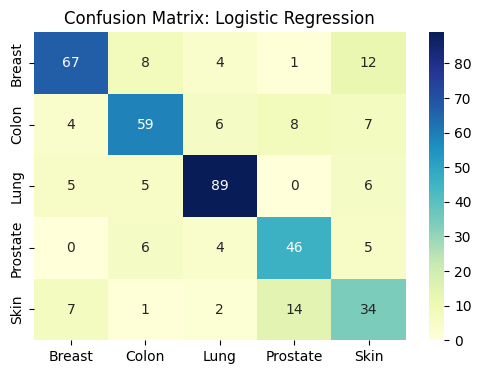

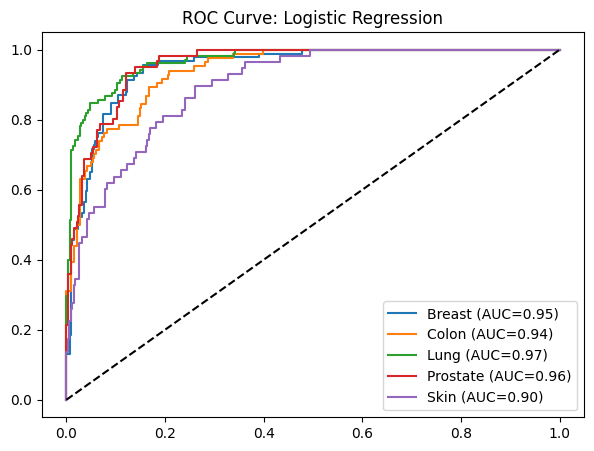

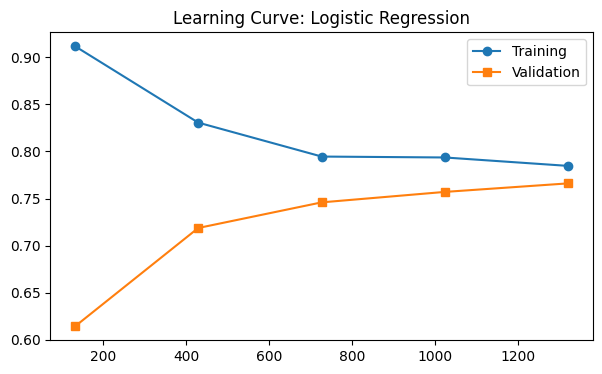


##################################################
 MODEL: Random Forest
##################################################

[1] 5-Fold Cross Validation Scores:
    Fold 1: 0.8338
    Fold 2: 0.8237
    Fold 3: 0.8413
    Fold 4: 0.8791
    Fold 5: 0.8157
    >>> Mean CV Accuracy: 0.8387

[2] Class-wise Metrics for Improved Random Forest:
              precision    recall  f1-score   support

      Breast       0.84      0.77      0.80        92
       Colon       0.78      0.74      0.76        84
        Lung       0.81      0.90      0.86       105
    Prostate       0.73      0.80      0.77        61
        Skin       0.65      0.59      0.62        58

    accuracy                           0.78       400
   macro avg       0.76      0.76      0.76       400
weighted avg       0.78      0.78      0.78       400



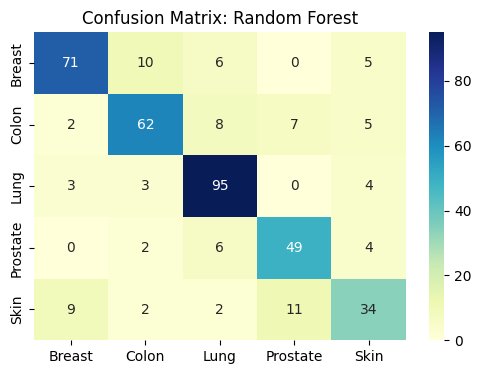

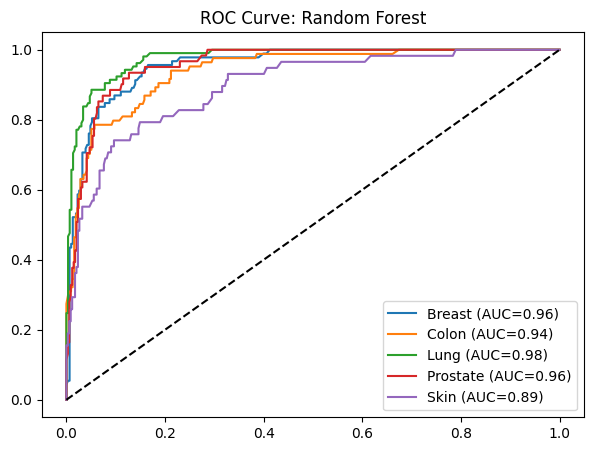

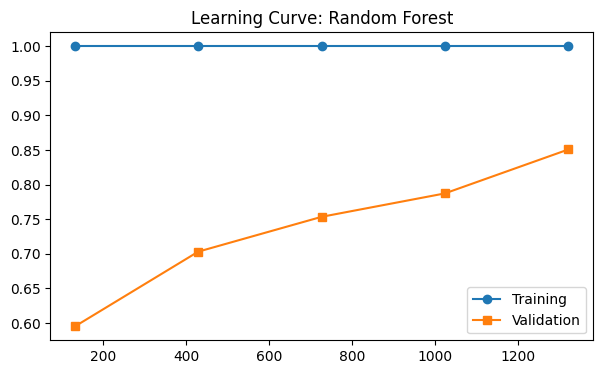


##################################################
 MODEL: XGBoost
##################################################

[1] 5-Fold Cross Validation Scores:
    Fold 1: 0.8388
    Fold 2: 0.8262
    Fold 3: 0.8438
    Fold 4: 0.8791
    Fold 5: 0.8308
    >>> Mean CV Accuracy: 0.8437

[2] Class-wise Metrics for Improved XGBoost:
              precision    recall  f1-score   support

      Breast       0.77      0.71      0.74        92
       Colon       0.78      0.80      0.79        84
        Lung       0.83      0.87      0.85       105
    Prostate       0.76      0.82      0.79        61
        Skin       0.59      0.55      0.57        58

    accuracy                           0.76       400
   macro avg       0.75      0.75      0.75       400
weighted avg       0.76      0.76      0.76       400



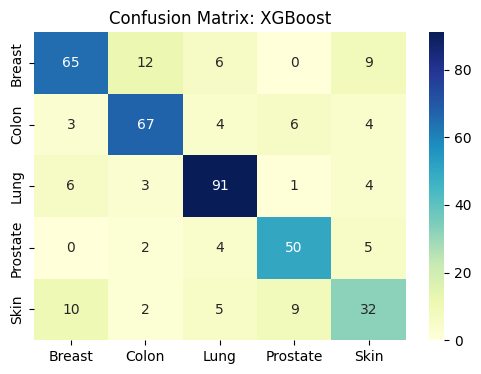

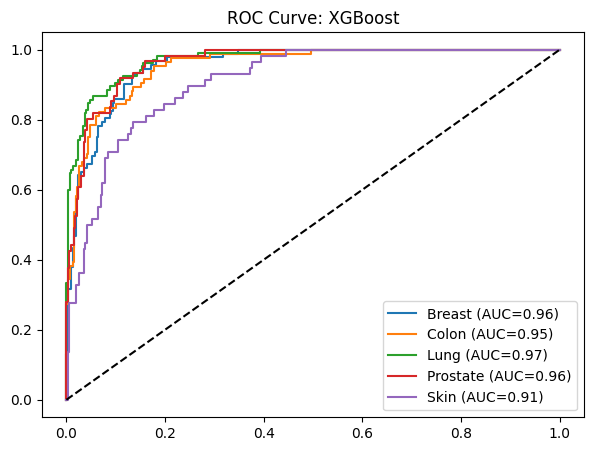

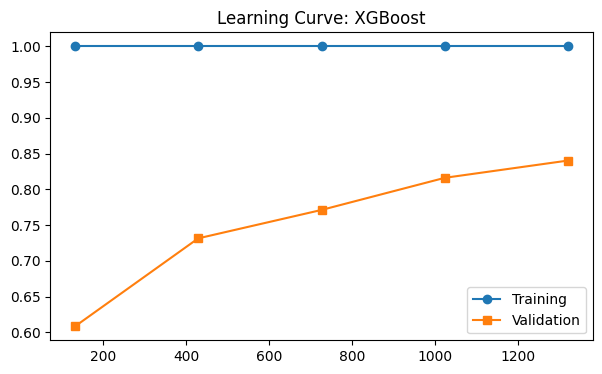


##################################################
 MODEL: SVM
##################################################

[1] 5-Fold Cross Validation Scores:
    Fold 1: 0.6751
    Fold 2: 0.6675
    Fold 3: 0.6977
    Fold 4: 0.7128
    Fold 5: 0.6970
    >>> Mean CV Accuracy: 0.6900

[2] Class-wise Metrics for Improved SVM:
              precision    recall  f1-score   support

      Breast       0.75      0.60      0.67        92
       Colon       0.67      0.71      0.69        84
        Lung       0.86      0.85      0.85       105
    Prostate       0.64      0.59      0.62        61
        Skin       0.51      0.69      0.59        58

    accuracy                           0.70       400
   macro avg       0.69      0.69      0.68       400
weighted avg       0.71      0.70      0.70       400



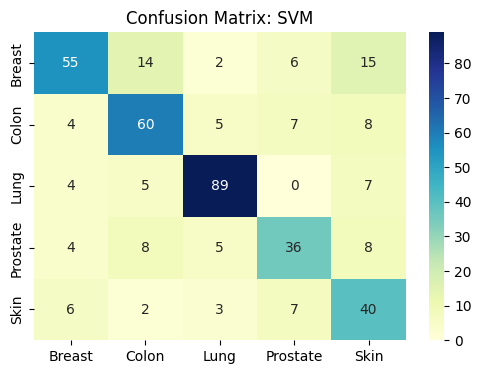

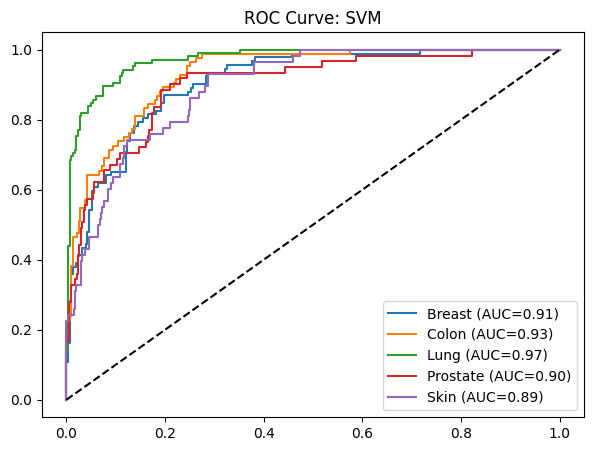

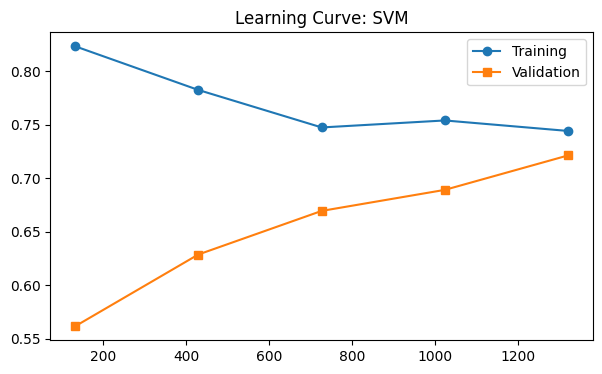


##################################################
 MODEL: KNN
##################################################

[1] 5-Fold Cross Validation Scores:
    Fold 1: 0.6952
    Fold 2: 0.6348
    Fold 3: 0.6499
    Fold 4: 0.6574
    Fold 5: 0.6389
    >>> Mean CV Accuracy: 0.6552

[2] Class-wise Metrics for Improved KNN:
              precision    recall  f1-score   support

      Breast       0.43      0.52      0.47        92
       Colon       0.52      0.44      0.48        84
        Lung       0.79      0.60      0.68       105
    Prostate       0.46      0.51      0.48        61
        Skin       0.33      0.40      0.36        58

    accuracy                           0.51       400
   macro avg       0.51      0.49      0.49       400
weighted avg       0.53      0.51      0.51       400



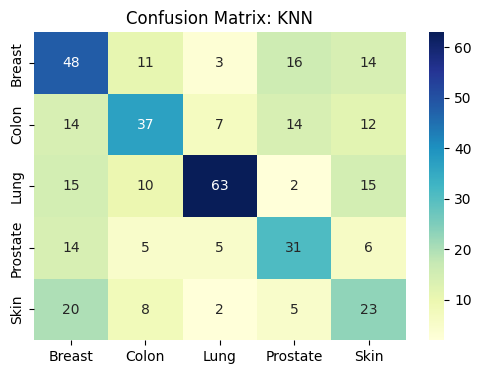

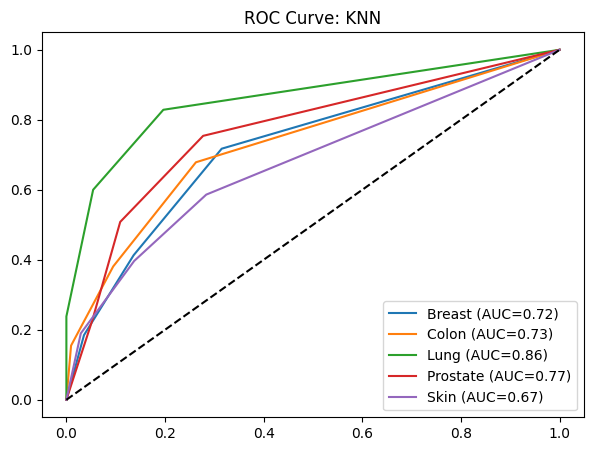

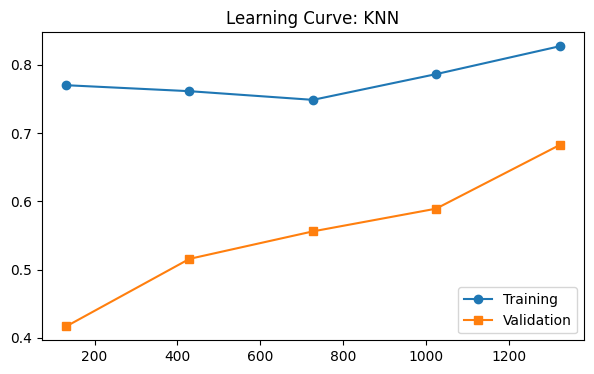


##################################################
 MODEL: Decision Tree
##################################################

[1] 5-Fold Cross Validation Scores:
    Fold 1: 0.7456
    Fold 2: 0.6851
    Fold 3: 0.7254
    Fold 4: 0.7305
    Fold 5: 0.7222
    >>> Mean CV Accuracy: 0.7218

[2] Class-wise Metrics for Improved Decision Tree:
              precision    recall  f1-score   support

      Breast       0.68      0.61      0.64        92
       Colon       0.57      0.55      0.56        84
        Lung       0.70      0.74      0.72       105
    Prostate       0.53      0.52      0.53        61
        Skin       0.48      0.55      0.52        58

    accuracy                           0.61       400
   macro avg       0.59      0.60      0.59       400
weighted avg       0.61      0.61      0.61       400



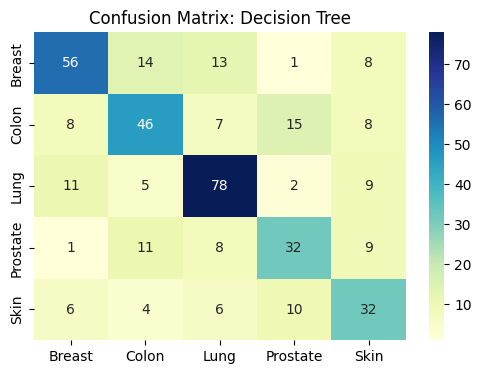

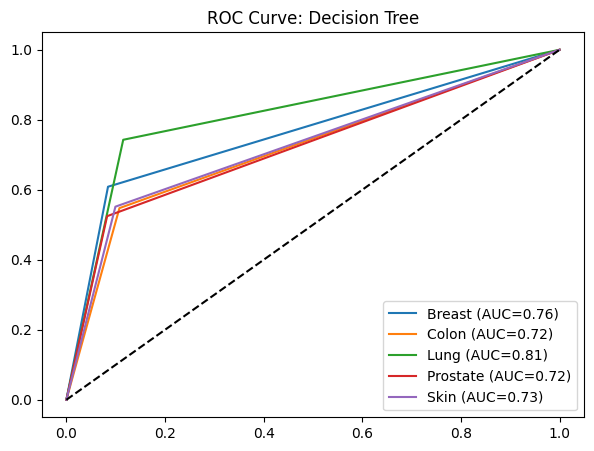

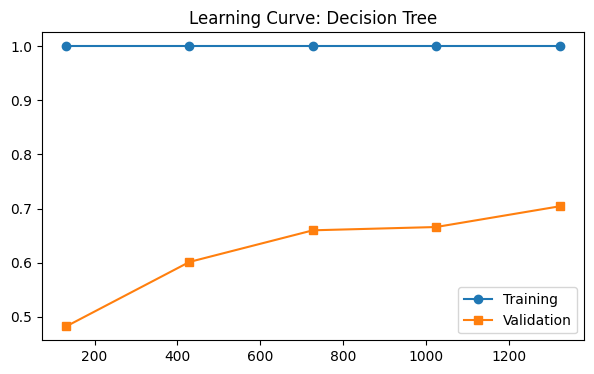


##################################################
 MODEL: AdaBoost
##################################################

[1] 5-Fold Cross Validation Scores:
    Fold 1: 0.6423
    Fold 2: 0.6474
    Fold 3: 0.6574
    Fold 4: 0.6851
    Fold 5: 0.6439
    >>> Mean CV Accuracy: 0.6552

[2] Class-wise Metrics for Improved AdaBoost:
              precision    recall  f1-score   support

      Breast       0.62      0.76      0.69        92
       Colon       0.79      0.40      0.54        84
        Lung       0.75      0.82      0.79       105
    Prostate       0.60      0.72      0.66        61
        Skin       0.50      0.50      0.50        58

    accuracy                           0.66       400
   macro avg       0.65      0.64      0.63       400
weighted avg       0.67      0.66      0.65       400



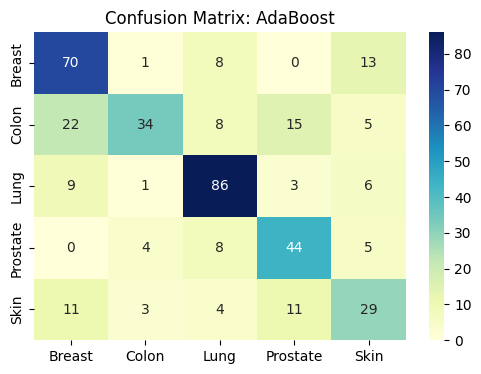

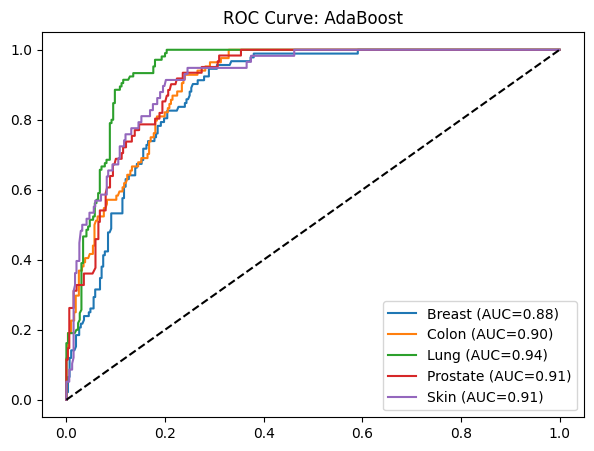

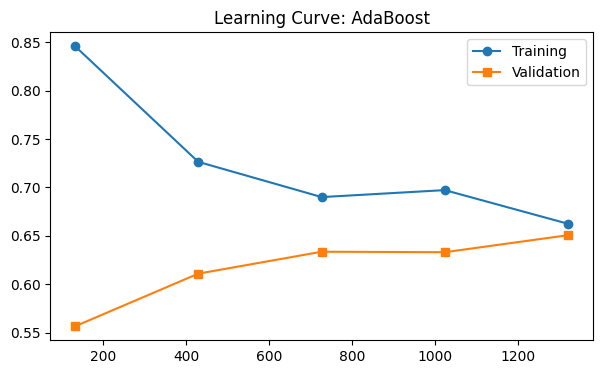

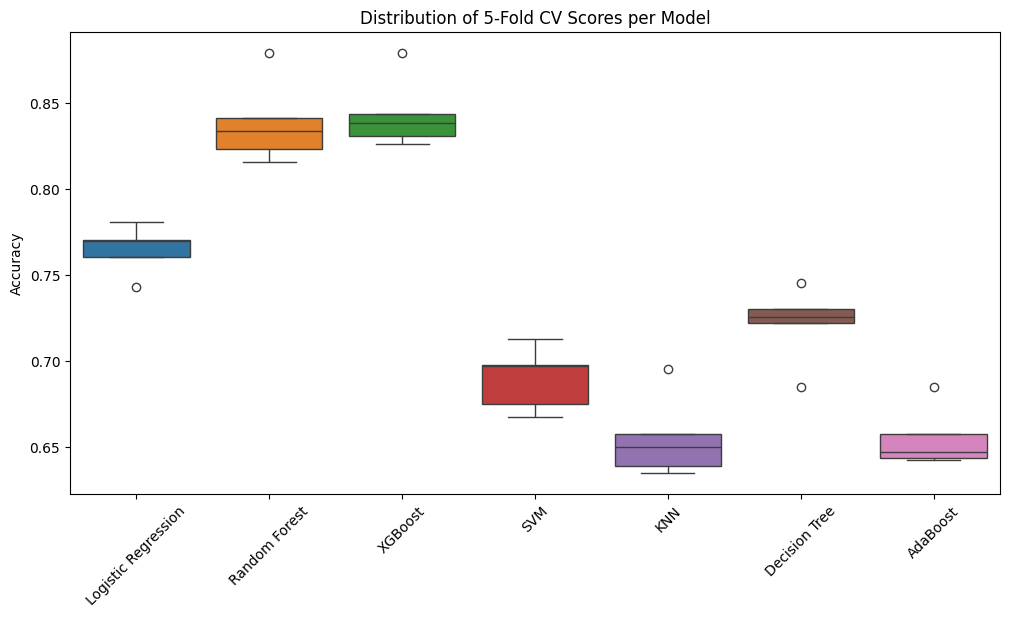


Processing Finished.


In [ ]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import (precision_score, recall_score, f1_score, classification_report,
                             accuracy_score, confusion_matrix, roc_curve, auc)

warnings.filterwarnings("ignore")

# ======================================================
# 1. LOAD & PREPROCESS
# ======================================================
dataset_path = "/content/cancer-risk-factors.csv"
df = pd.read_csv(dataset_path)

df.drop(columns=["Patient_ID", "Risk_Level"], inplace=True, errors='ignore')

le_target = LabelEncoder()
df["Cancer_Type"] = le_target.fit_transform(df["Cancer_Type"])
target_names = le_target.classes_
n_classes = len(target_names)

cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=["Cancer_Type"])
y = df["Cancer_Type"]

imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

# ======================================================
# 2. MODELS & PARAM GRIDS
# ======================================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

param_grids = {
    "Logistic Regression": {'C': [0.1, 1, 10]},
    "Random Forest": {'n_estimators': [300, 500], 'max_depth': [10, 20]},
    "XGBoost": {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.3]},
    "SVM": {'C': [1, 10], 'kernel': ['rbf']},
    "KNN": {'n_neighbors': [3, 5, 7]},
    "Decision Tree": {'max_depth': [10, 20]},
    "AdaBoost": {'n_estimators': [50, 100]}
}

# ======================================================
# 3. TRAINING & DETAILED EVALUATION
# ======================================================
results = {}
all_cv_scores = []

for model_name, model in models.items():
    print(f"\n{'#'*50}")
    print(f" MODEL: {model_name}")
    print(f"{'#'*50}")

    # --- A. 5-Fold Cross Validation (Every Fold Result) ---
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_res, y_train_res, cv=skf)
    all_cv_scores.append(cv_scores)

    print("\n[1] 5-Fold Cross Validation Scores:")
    for i, score in enumerate(cv_scores):
        print(f"    Fold {i+1}: {score:.4f}")
    print(f"    >>> Mean CV Accuracy: {np.mean(cv_scores):.4f}")

    # --- B. GridSearchCV (Improved Accuracy) ---
    grid_search = GridSearchCV(model, param_grids[model_name], cv=3, n_jobs=-1)
    grid_search.fit(X_train_res, y_train_res)
    best_model = grid_search.best_estimator_
    improved_acc = grid_search.best_score_

    # --- C. Class-wise Metrics (Improved/Best Model) ---
    y_pred_test = best_model.predict(X_test)
    print(f"\n[2] Class-wise Metrics for Improved {model_name}:")
    report = classification_report(y_test, y_pred_test, target_names=target_names)
    print(report)

    # --- D. Visualizations ---
    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=target_names, yticklabels=target_names)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()



    # ROC Curve
    if hasattr(best_model, "predict_proba"):
        y_prob = best_model.predict_proba(X_test)
        y_test_bin = label_binarize(y_test, classes=range(n_classes))
        plt.figure(figsize=(7, 5))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            plt.plot(fpr, tpr, label=f'{target_names[i]} (AUC={auc(fpr, tpr):.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f"ROC Curve: {model_name}")
        plt.legend()
        plt.show()



    # Learning Curve
    sz, tr_sc, val_sc = learning_curve(best_model, X_train_res, y_train_res, cv=3)
    plt.figure(figsize=(7, 4))
    plt.plot(sz, np.mean(tr_sc, axis=1), 'o-', label="Training")
    plt.plot(sz, np.mean(val_sc, axis=1), 's-', label="Validation")
    plt.title(f"Learning Curve: {model_name}")
    plt.legend()
    plt.show()



# ======================================================
# 4. FINAL COMPARISON GRAPH (Every Fold Score)
# ======================================================
plt.figure(figsize=(12, 6))
sns.boxplot(data=all_cv_scores)
plt.xticks(range(len(models)), list(models.keys()), rotation=45)
plt.title('Distribution of 5-Fold CV Scores per Model')
plt.ylabel('Accuracy')
plt.show()



print("\nProcessing Finished.")


 EVALUATING MODEL: Logistic Regression

>> 5-Fold Scores:
   Fold 1: 0.7607
   Fold 2: 0.7431
   Fold 3: 0.7809
   Fold 4: 0.7708
   Fold 5: 0.7702
   Mean Accuracy: 0.7651

>> Best Params: {'C': 10}
>> Improved Accuracy (Train): 0.7687

>> Class-wise Report for Logistic Regression:
              precision    recall  f1-score   support

      Breast       0.81      0.73      0.77        92
       Colon       0.75      0.70      0.72        84
        Lung       0.85      0.85      0.85       105
    Prostate       0.67      0.75      0.71        61
        Skin       0.53      0.59      0.56        58

    accuracy                           0.74       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.74      0.74      0.74       400



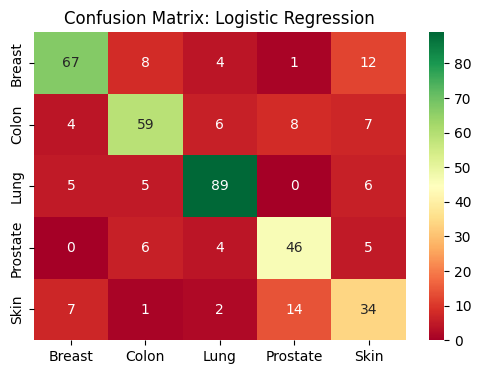

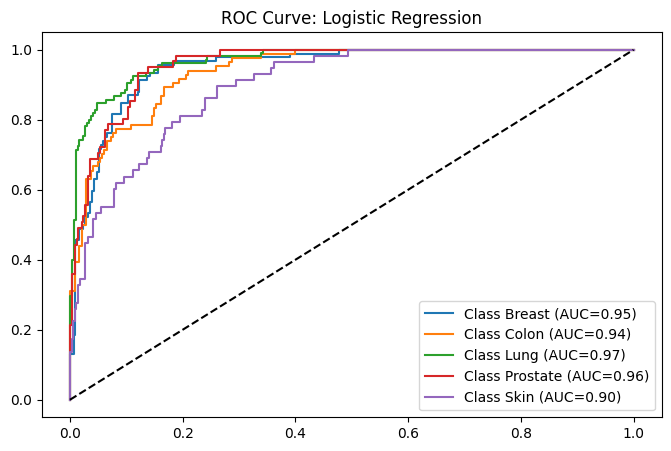


 EVALUATING MODEL: Random Forest

>> 5-Fold Scores:
   Fold 1: 0.8338
   Fold 2: 0.8237
   Fold 3: 0.8413
   Fold 4: 0.8791
   Fold 5: 0.8157
   Mean Accuracy: 0.8387

>> Best Params: {'max_depth': 20, 'n_estimators': 300}
>> Improved Accuracy (Train): 0.8453

>> Class-wise Report for Random Forest:
              precision    recall  f1-score   support

      Breast       0.85      0.77      0.81        92
       Colon       0.77      0.75      0.76        84
        Lung       0.81      0.91      0.86       105
    Prostate       0.74      0.79      0.76        61
        Skin       0.67      0.59      0.62        58

    accuracy                           0.78       400
   macro avg       0.77      0.76      0.76       400
weighted avg       0.78      0.78      0.78       400



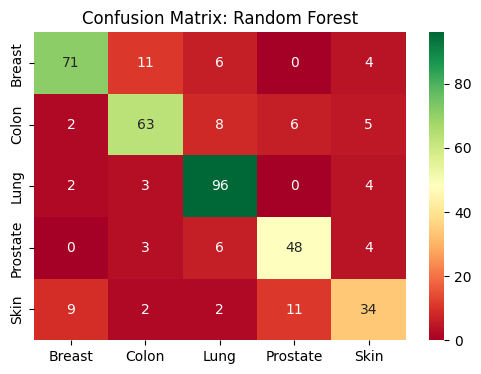

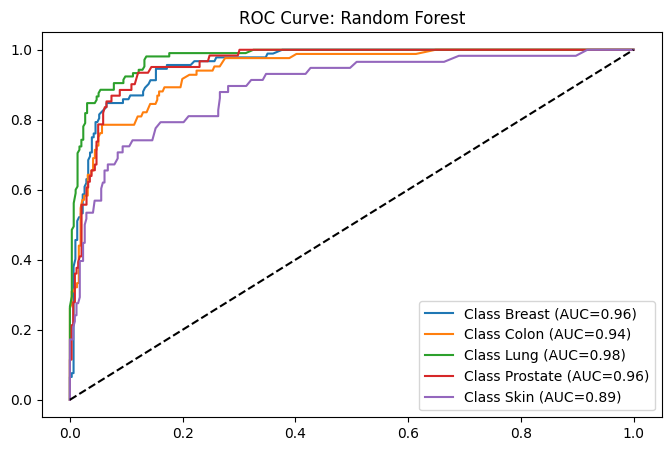


 EVALUATING MODEL: XGBoost

>> 5-Fold Scores:
   Fold 1: 0.8388
   Fold 2: 0.8262
   Fold 3: 0.8438
   Fold 4: 0.8791
   Fold 5: 0.8308
   Mean Accuracy: 0.8437

>> Best Params: {'learning_rate': 0.3, 'n_estimators': 100}
>> Improved Accuracy (Train): 0.8367

>> Class-wise Report for XGBoost:
              precision    recall  f1-score   support

      Breast       0.77      0.71      0.74        92
       Colon       0.78      0.80      0.79        84
        Lung       0.83      0.87      0.85       105
    Prostate       0.76      0.82      0.79        61
        Skin       0.59      0.55      0.57        58

    accuracy                           0.76       400
   macro avg       0.75      0.75      0.75       400
weighted avg       0.76      0.76      0.76       400



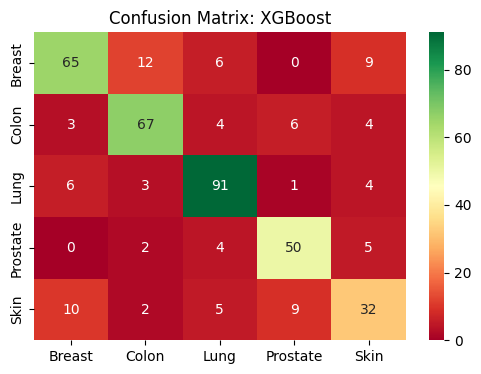

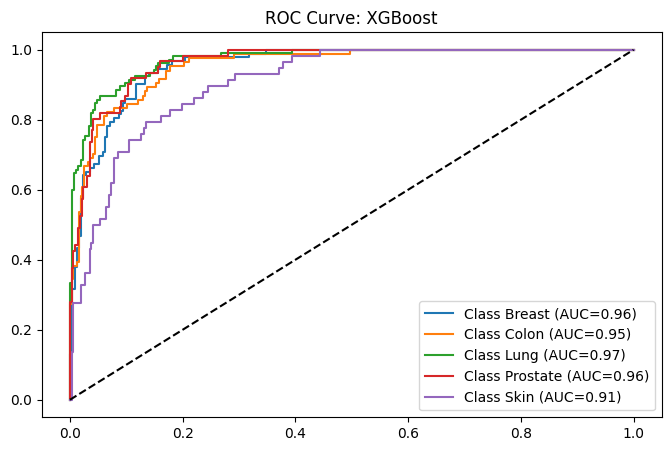


 EVALUATING MODEL: SVM

>> 5-Fold Scores:
   Fold 1: 0.6751
   Fold 2: 0.6675
   Fold 3: 0.6977
   Fold 4: 0.7128
   Fold 5: 0.6970
   Mean Accuracy: 0.6900

>> Best Params: {'C': 10, 'kernel': 'rbf'}
>> Improved Accuracy (Train): 0.7218

>> Class-wise Report for SVM:
              precision    recall  f1-score   support

      Breast       0.75      0.60      0.67        92
       Colon       0.67      0.71      0.69        84
        Lung       0.86      0.85      0.85       105
    Prostate       0.64      0.59      0.62        61
        Skin       0.51      0.69      0.59        58

    accuracy                           0.70       400
   macro avg       0.69      0.69      0.68       400
weighted avg       0.71      0.70      0.70       400



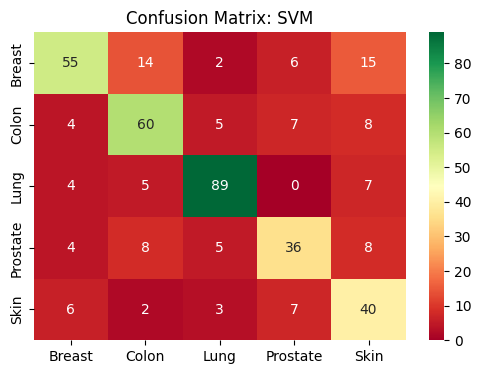

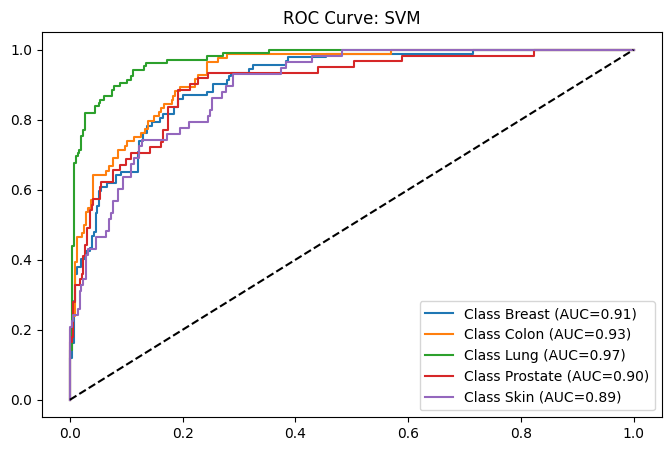


 EVALUATING MODEL: KNN

>> 5-Fold Scores:
   Fold 1: 0.6952
   Fold 2: 0.6348
   Fold 3: 0.6499
   Fold 4: 0.6574
   Fold 5: 0.6389
   Mean Accuracy: 0.6552

>> Best Params: {'n_neighbors': 3}
>> Improved Accuracy (Train): 0.6825

>> Class-wise Report for KNN:
              precision    recall  f1-score   support

      Breast       0.43      0.52      0.47        92
       Colon       0.52      0.44      0.48        84
        Lung       0.79      0.60      0.68       105
    Prostate       0.46      0.51      0.48        61
        Skin       0.33      0.40      0.36        58

    accuracy                           0.51       400
   macro avg       0.51      0.49      0.49       400
weighted avg       0.53      0.51      0.51       400



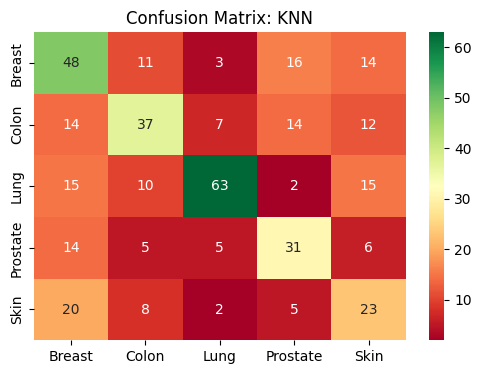

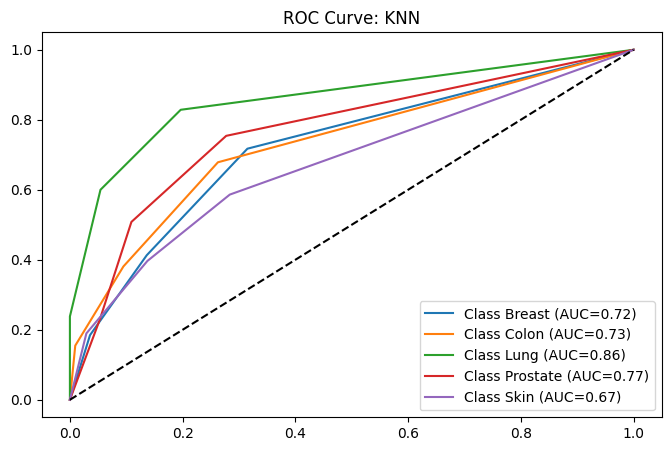


 EVALUATING MODEL: Decision Tree

>> 5-Fold Scores:
   Fold 1: 0.7456
   Fold 2: 0.6851
   Fold 3: 0.7254
   Fold 4: 0.7305
   Fold 5: 0.7222
   Mean Accuracy: 0.7218

>> Best Params: {'max_depth': 20}
>> Improved Accuracy (Train): 0.7057

>> Class-wise Report for Decision Tree:
              precision    recall  f1-score   support

      Breast       0.68      0.61      0.64        92
       Colon       0.57      0.55      0.56        84
        Lung       0.70      0.74      0.72       105
    Prostate       0.53      0.52      0.53        61
        Skin       0.48      0.55      0.52        58

    accuracy                           0.61       400
   macro avg       0.59      0.60      0.59       400
weighted avg       0.61      0.61      0.61       400



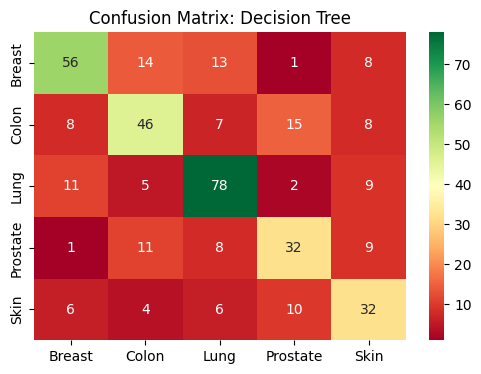

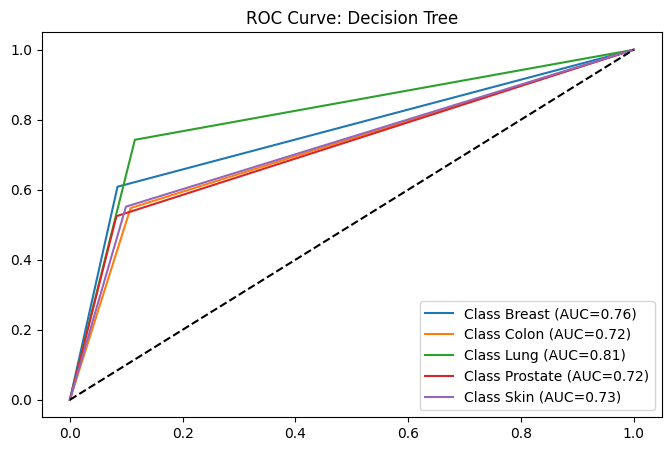


 EVALUATING MODEL: AdaBoost

>> 5-Fold Scores:
   Fold 1: 0.6423
   Fold 2: 0.6474
   Fold 3: 0.6574
   Fold 4: 0.6851
   Fold 5: 0.6439
   Mean Accuracy: 0.6552

>> Best Params: {'n_estimators': 100}
>> Improved Accuracy (Train): 0.6507

>> Class-wise Report for AdaBoost:
              precision    recall  f1-score   support

      Breast       0.62      0.76      0.69        92
       Colon       0.79      0.40      0.54        84
        Lung       0.75      0.82      0.79       105
    Prostate       0.60      0.72      0.66        61
        Skin       0.50      0.50      0.50        58

    accuracy                           0.66       400
   macro avg       0.65      0.64      0.63       400
weighted avg       0.67      0.66      0.65       400



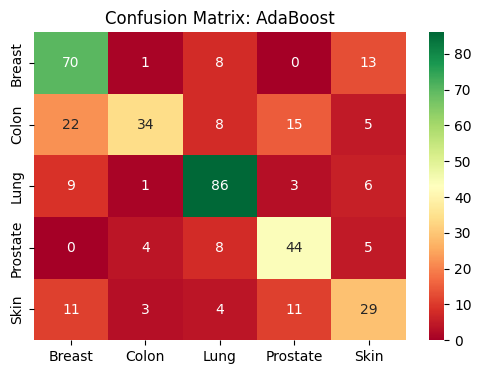

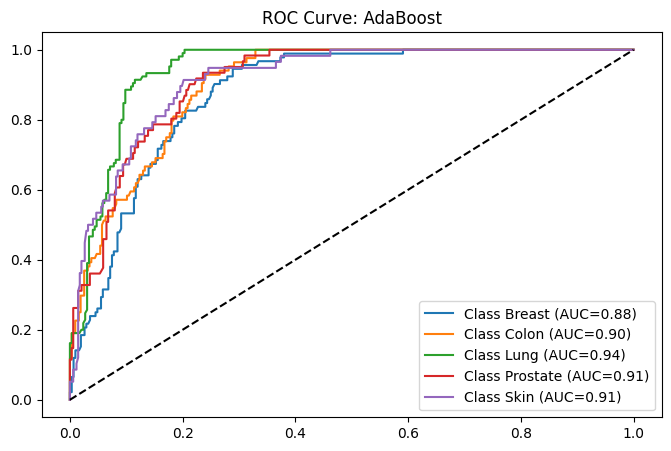


 EVALUATING MODEL: Voting Classifier

>> 5-Fold Scores:
   Fold 1: 0.7809
   Fold 2: 0.7632
   Fold 3: 0.7935
   Fold 4: 0.8010
   Fold 5: 0.7854
   Mean Accuracy: 0.7848

>> Using default ensemble parameters (No GridSearchCV).

>> Class-wise Report for Voting Classifier:
              precision    recall  f1-score   support

      Breast       0.81      0.68      0.74        92
       Colon       0.73      0.74      0.73        84
        Lung       0.85      0.87      0.86       105
    Prostate       0.72      0.72      0.72        61
        Skin       0.52      0.62      0.57        58

    accuracy                           0.74       400
   macro avg       0.73      0.73      0.72       400
weighted avg       0.75      0.74      0.74       400



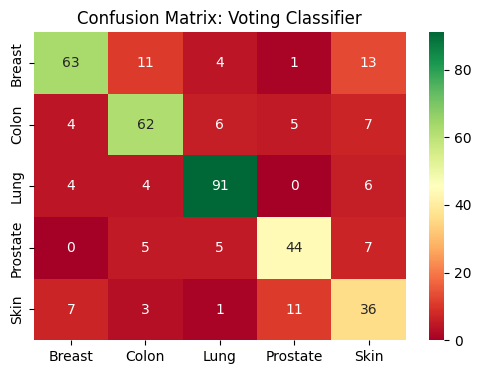

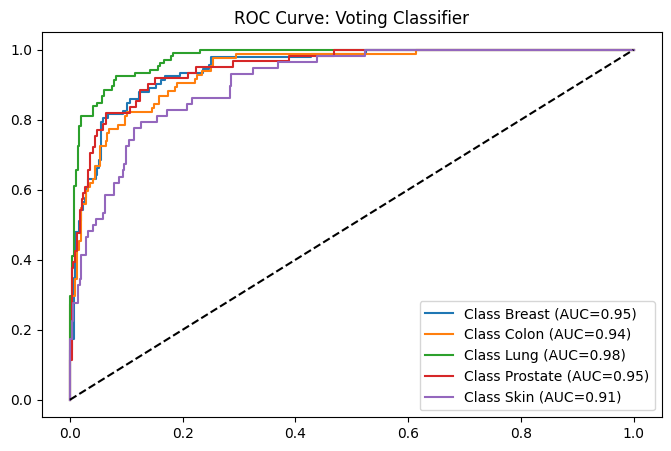


 EVALUATING MODEL: Stacking Classifier

>> 5-Fold Scores:
   Fold 1: 0.8338
   Fold 2: 0.8388
   Fold 3: 0.8463
   Fold 4: 0.8690
   Fold 5: 0.8333
   Mean Accuracy: 0.8442

>> Using default ensemble parameters (No GridSearchCV).

>> Class-wise Report for Stacking Classifier:
              precision    recall  f1-score   support

      Breast       0.82      0.79      0.81        92
       Colon       0.70      0.79      0.74        84
        Lung       0.84      0.86      0.85       105
    Prostate       0.76      0.74      0.75        61
        Skin       0.61      0.53      0.57        58

    accuracy                           0.76       400
   macro avg       0.75      0.74      0.74       400
weighted avg       0.76      0.76      0.76       400



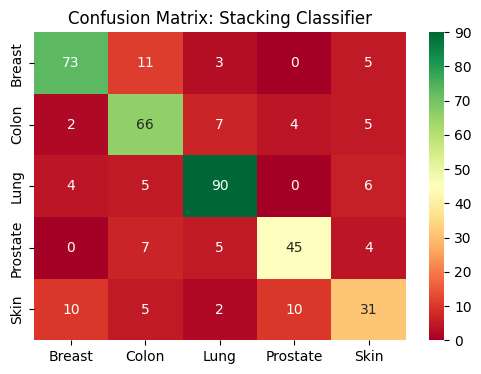

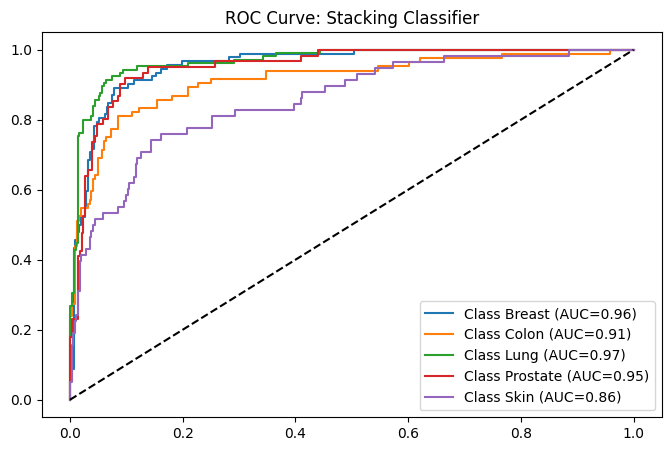

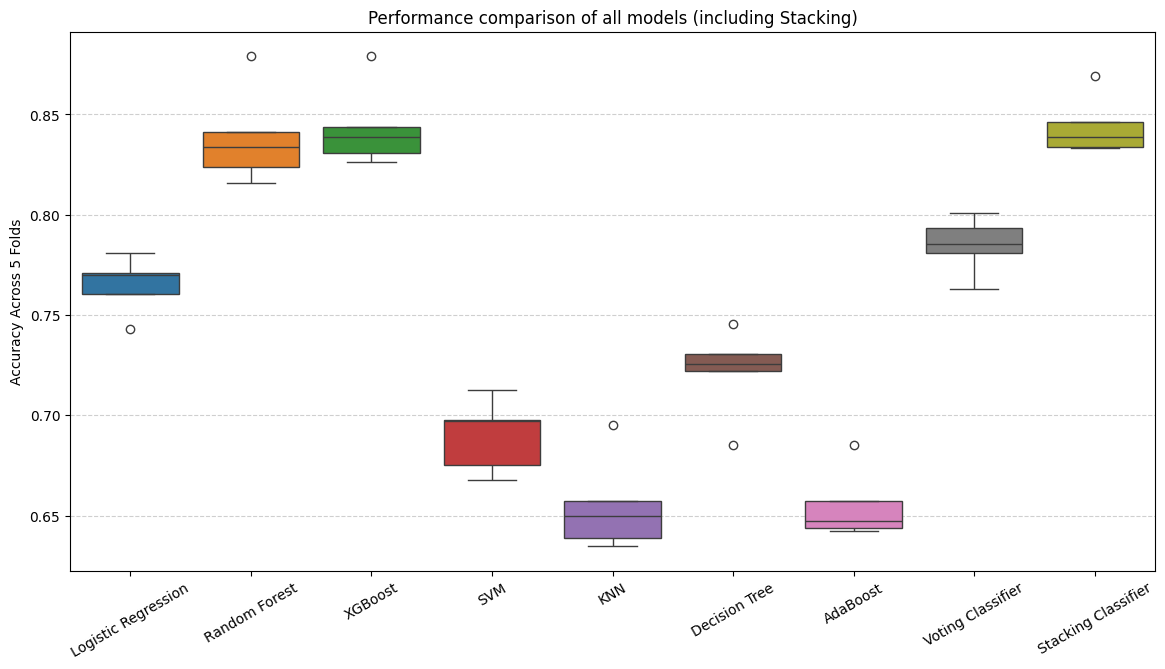


All models including Stacking have been evaluated.


In [ ]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import (precision_score, recall_score, f1_score, classification_report,
                             accuracy_score, confusion_matrix, roc_curve, auc)

warnings.filterwarnings("ignore")

# ======================================================
# 1. LOAD & PREPROCESS
# ======================================================
dataset_path = "/content/cancer-risk-factors.csv"
df = pd.read_csv(dataset_path)

df.drop(columns=["Patient_ID", "Risk_Level"], inplace=True, errors='ignore')

le_target = LabelEncoder()
df["Cancer_Type"] = le_target.fit_transform(df["Cancer_Type"])
target_names = le_target.classes_
n_classes = len(target_names)

cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=["Cancer_Type"])
y = df["Cancer_Type"]

imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

# ======================================================
# 2. MODELS DEFINITION (Including Stacking & Voting)
# ======================================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Voting Classifier": VotingClassifier(estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True))
    ], voting='soft'),
    "Stacking Classifier": StackingClassifier(
        estimators=[('lr', LogisticRegression(max_iter=1000)),
                    ('rf', RandomForestClassifier(random_state=42)),
                    ('knn', KNeighborsClassifier())],
        final_estimator=LogisticRegression(),
        passthrough=False
    )
}

# Parameters for Tuning
param_grids = {
    "Logistic Regression": {'C': [0.1, 1, 10]},
    "Random Forest": {'n_estimators': [100, 300], 'max_depth': [10, 20]},
    "XGBoost": {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.3]},
    "SVM": {'C': [1, 10], 'kernel': ['rbf']},
    "KNN": {'n_neighbors': [3, 5, 7]},
    "Decision Tree": {'max_depth': [10, 20]},
    "AdaBoost": {'n_estimators': [50, 100]},
    "Voting Classifier": {}, # No tuning for ensemble
    "Stacking Classifier": {} # No tuning for ensemble
}

# ======================================================
# 3. COMPREHENSIVE LOOP FOR ALL MODELS
# ======================================================
all_cv_scores = []

for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f" EVALUATING MODEL: {model_name}")
    print(f"{'='*60}")

    # --- 1. Every Fold Score (5-Fold CV) ---
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_res, y_train_res, cv=skf)
    all_cv_scores.append(cv_scores)

    print("\n>> 5-Fold Scores:")
    for idx, s in enumerate(cv_scores):
        print(f"   Fold {idx+1}: {s:.4f}")
    print(f"   Mean Accuracy: {np.mean(cv_scores):.4f}")

    # --- 2. Training with Best Params (if any) ---
    if param_grids[model_name]:
        grid = GridSearchCV(model, param_grids[model_name], cv=3, n_jobs=-1)
        grid.fit(X_train_res, y_train_res)
        final_model = grid.best_estimator_
        print(f"\n>> Best Params: {grid.best_params_}")
        print(f">> Improved Accuracy (Train): {grid.best_score_:.4f}")
    else:
        final_model = model.fit(X_train_res, y_train_res)
        print("\n>> Using default ensemble parameters (No GridSearchCV).")

    # --- 3. Class-wise Metrics (Precision, Recall, F1) ---
    y_pred = final_model.predict(X_test)
    print(f"\n>> Class-wise Report for {model_name}:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    # --- 4. Graphical Results ---
    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', xticklabels=target_names, yticklabels=target_names)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()



    # Multi-class ROC
    if hasattr(final_model, "predict_proba"):
        y_prob = final_model.predict_proba(X_test)
        y_test_bin = label_binarize(y_test, classes=range(n_classes))
        plt.figure(figsize=(8, 5))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            plt.plot(fpr, tpr, label=f'Class {target_names[i]} (AUC={auc(fpr, tpr):.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f"ROC Curve: {model_name}")
        plt.legend()
        plt.show()



# ======================================================
# 4. FINAL CROSS-VALIDATION BOXPLOT
# ======================================================
plt.figure(figsize=(14, 7))
sns.boxplot(data=all_cv_scores)
plt.xticks(range(len(models)), list(models.keys()), rotation=30)
plt.title('Performance comparison of all models (including Stacking)')
plt.ylabel('Accuracy Across 5 Folds')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()



print("\nAll models including Stacking have been evaluated.")


Training Logistic Regression...
Every Fold Scores: [0.76070529 0.74307305 0.78085642 0.77078086 0.77020202]
Mean CV Accuracy: 0.7651
              precision    recall  f1-score   support

      Breast       0.80      0.72      0.75        92
       Colon       0.76      0.70      0.73        84
        Lung       0.86      0.85      0.85       105
    Prostate       0.67      0.75      0.71        61
        Skin       0.53      0.60      0.56        58

    accuracy                           0.74       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.74      0.74      0.74       400


Training Random Forest...
Every Fold Scores: [0.83375315 0.82367758 0.84130982 0.8790932  0.81565657]
Mean CV Accuracy: 0.8387
              precision    recall  f1-score   support

      Breast       0.84      0.78      0.81        92
       Colon       0.79      0.75      0.77        84
        Lung       0.83      0.92      0.87       105
    Prostate       0.75      0.7

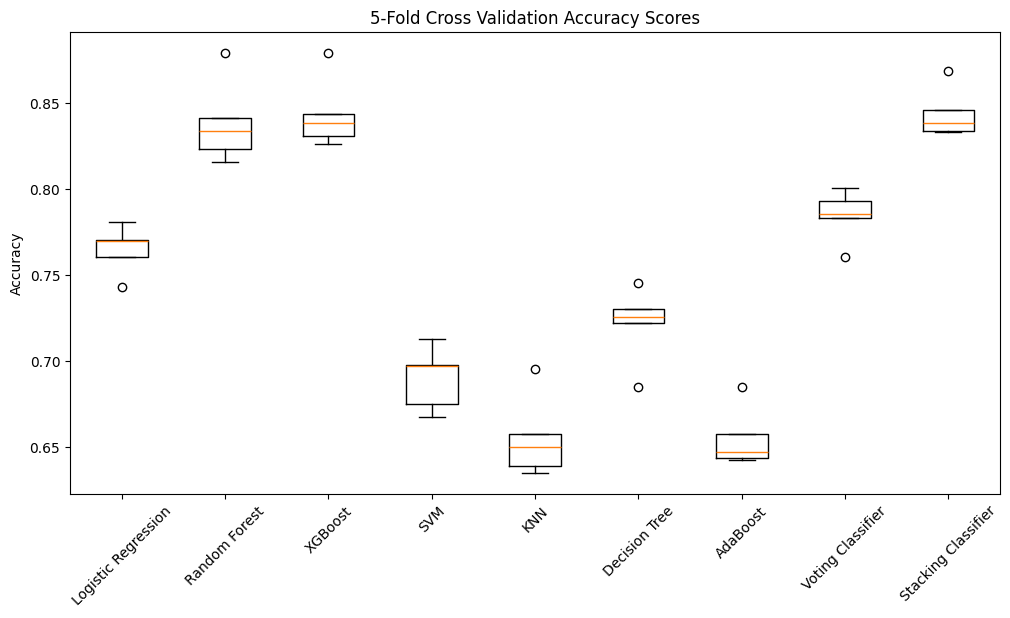

In [ ]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score, confusion_matrix

warnings.filterwarnings("ignore")

# ======================================================
# 1. LOAD & PREPROCESS
# ======================================================
dataset_path = "/content/cancer-risk-factors.csv"
df = pd.read_csv(dataset_path)

# ড্রপ কলাম
df.drop(columns=["Patient_ID", "Risk_Level"], inplace=True, errors='ignore')

# টার্গেট এনকোডিং
le_target = LabelEncoder()
df["Cancer_Type"] = le_target.fit_transform(df["Cancer_Type"])
target_names = le_target.classes_

# ফিচার এনকোডিং
cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=["Cancer_Type"])
y = df["Cancer_Type"]

# মিসিং ভ্যালু ইমপুটেশন
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)

# স্প্লিট ডেটা
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ব্যালেন্সিং
smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

# ======================================================
# 2. DEFINE MODELS (No Hyperparameters)
# ======================================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Voting Classifier": VotingClassifier(estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True))
    ], voting='soft'),
    "Stacking Classifier": StackingClassifier(
        estimators=[('lr', LogisticRegression(max_iter=1000)),
                    ('rf', RandomForestClassifier(random_state=42)),
                    ('knn', KNeighborsClassifier())],
        final_estimator=LogisticRegression()
    )
}

# রেজাল্ট স্টোরেজ
results = {}
all_cv_scores = []

# ======================================================
# 3. TRAINING & EVALUATION
# ======================================================
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # ৫-ফোল্ড ক্রস ভ্যালিডেশন (ফোল্ড ভিত্তিক রেজাল্ট)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_res, y_train_res, cv=skf)
    all_cv_scores.append(cv_scores)

    # মডেল ফিট
    model.fit(X_train_res, y_train_res)

    # প্রেডিকশন
    y_pred = model.predict(X_test)

    # মেট্রিক্স গণনা (Test Set)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # স্টোর রেজাল্ট
    results[model_name] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'CV Mean': np.mean(cv_scores)
    }

    # আউটপুট প্রিন্ট
    print(f"Every Fold Scores: {cv_scores}")
    print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")
    print(classification_report(y_test, y_pred, target_names=target_names))

# ======================================================
# 4. FINAL SUMMARY TABLE
# ======================================================
results_df = pd.DataFrame(results).T
print("\n===== FINAL MODEL COMPARISON =====")
print(results_df)

# গ্রাফিক্যাল ভিউ (বক্সপ্লট)
plt.figure(figsize=(12, 6))
plt.boxplot(all_cv_scores, labels=list(models.keys()))
plt.title('5-Fold Cross Validation Accuracy Scores')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.show()

Dataset Shape: (2000, 21)

Missing Values:
 Patient_ID                 0
Cancer_Type                0
Age                        0
Gender                     0
Smoking                    0
Alcohol_Use                0
Obesity                    0
Family_History             0
Diet_Red_Meat              0
Diet_Salted_Processed      0
Fruit_Veg_Intake           0
Physical_Activity          0
Air_Pollution              0
Occupational_Hazards       0
BRCA_Mutation              0
H_Pylori_Infection         0
Calcium_Intake             0
Overall_Risk_Score         0
BMI                        0
Physical_Activity_Level    0
Risk_Level                 0
dtype: int64


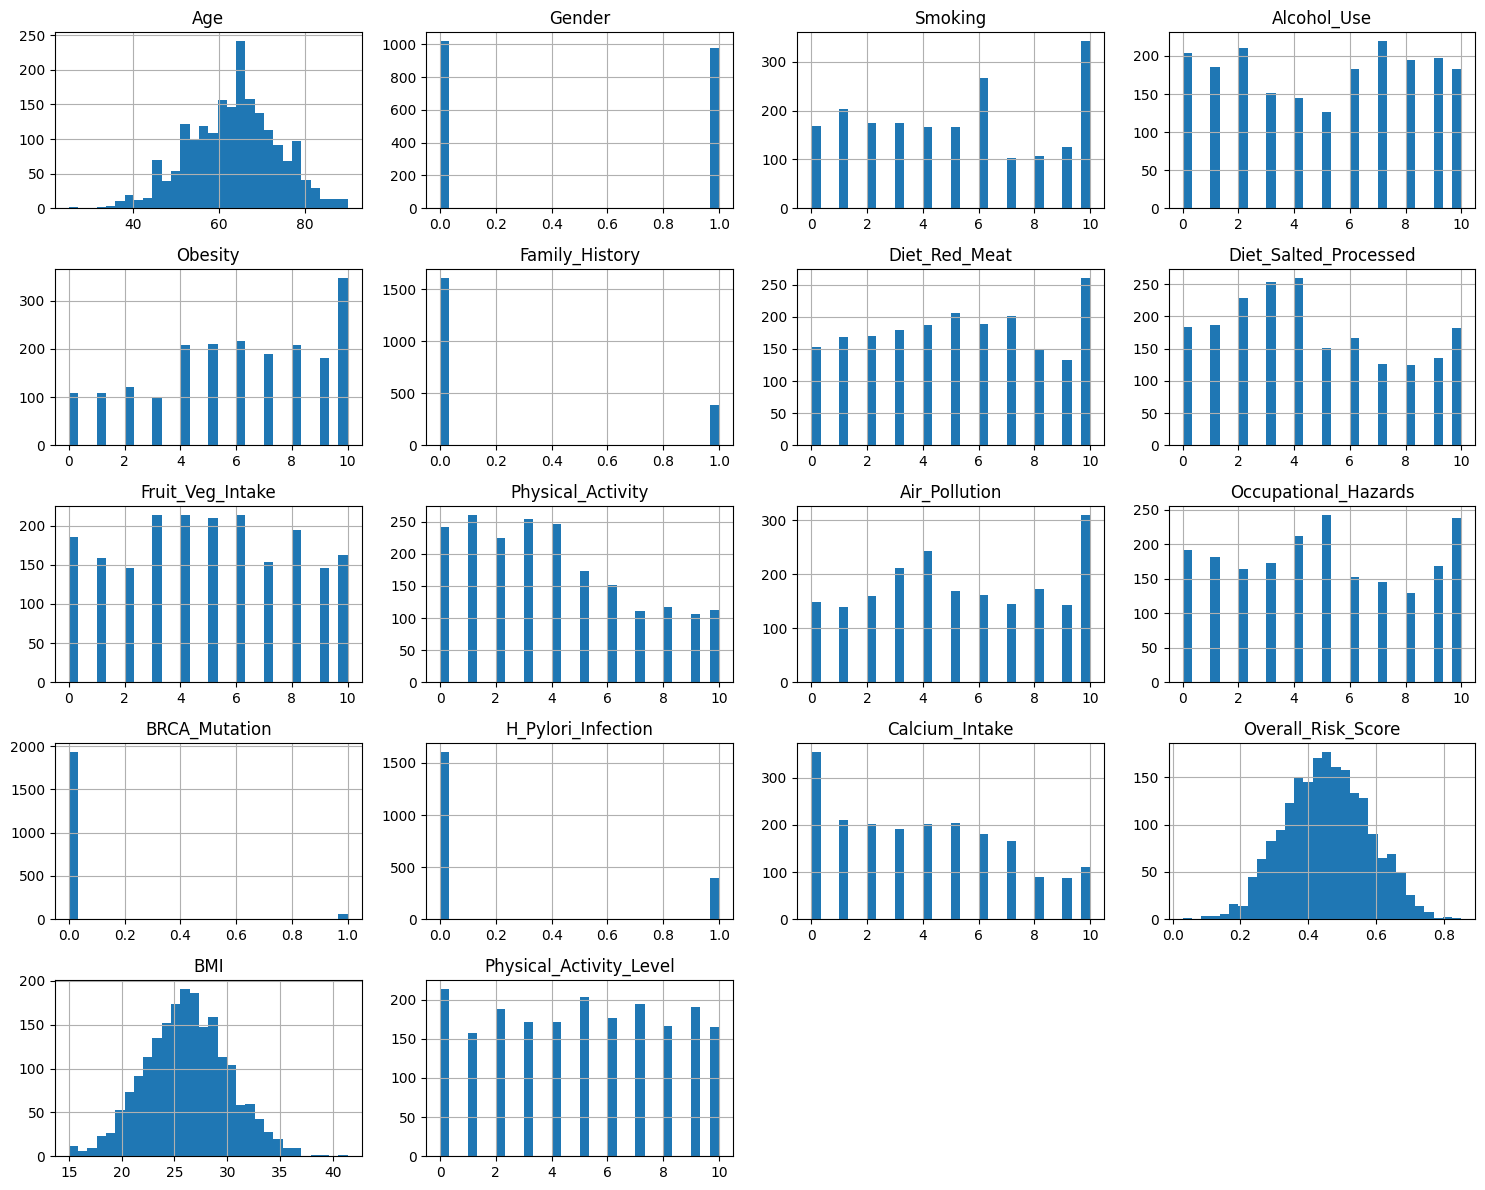

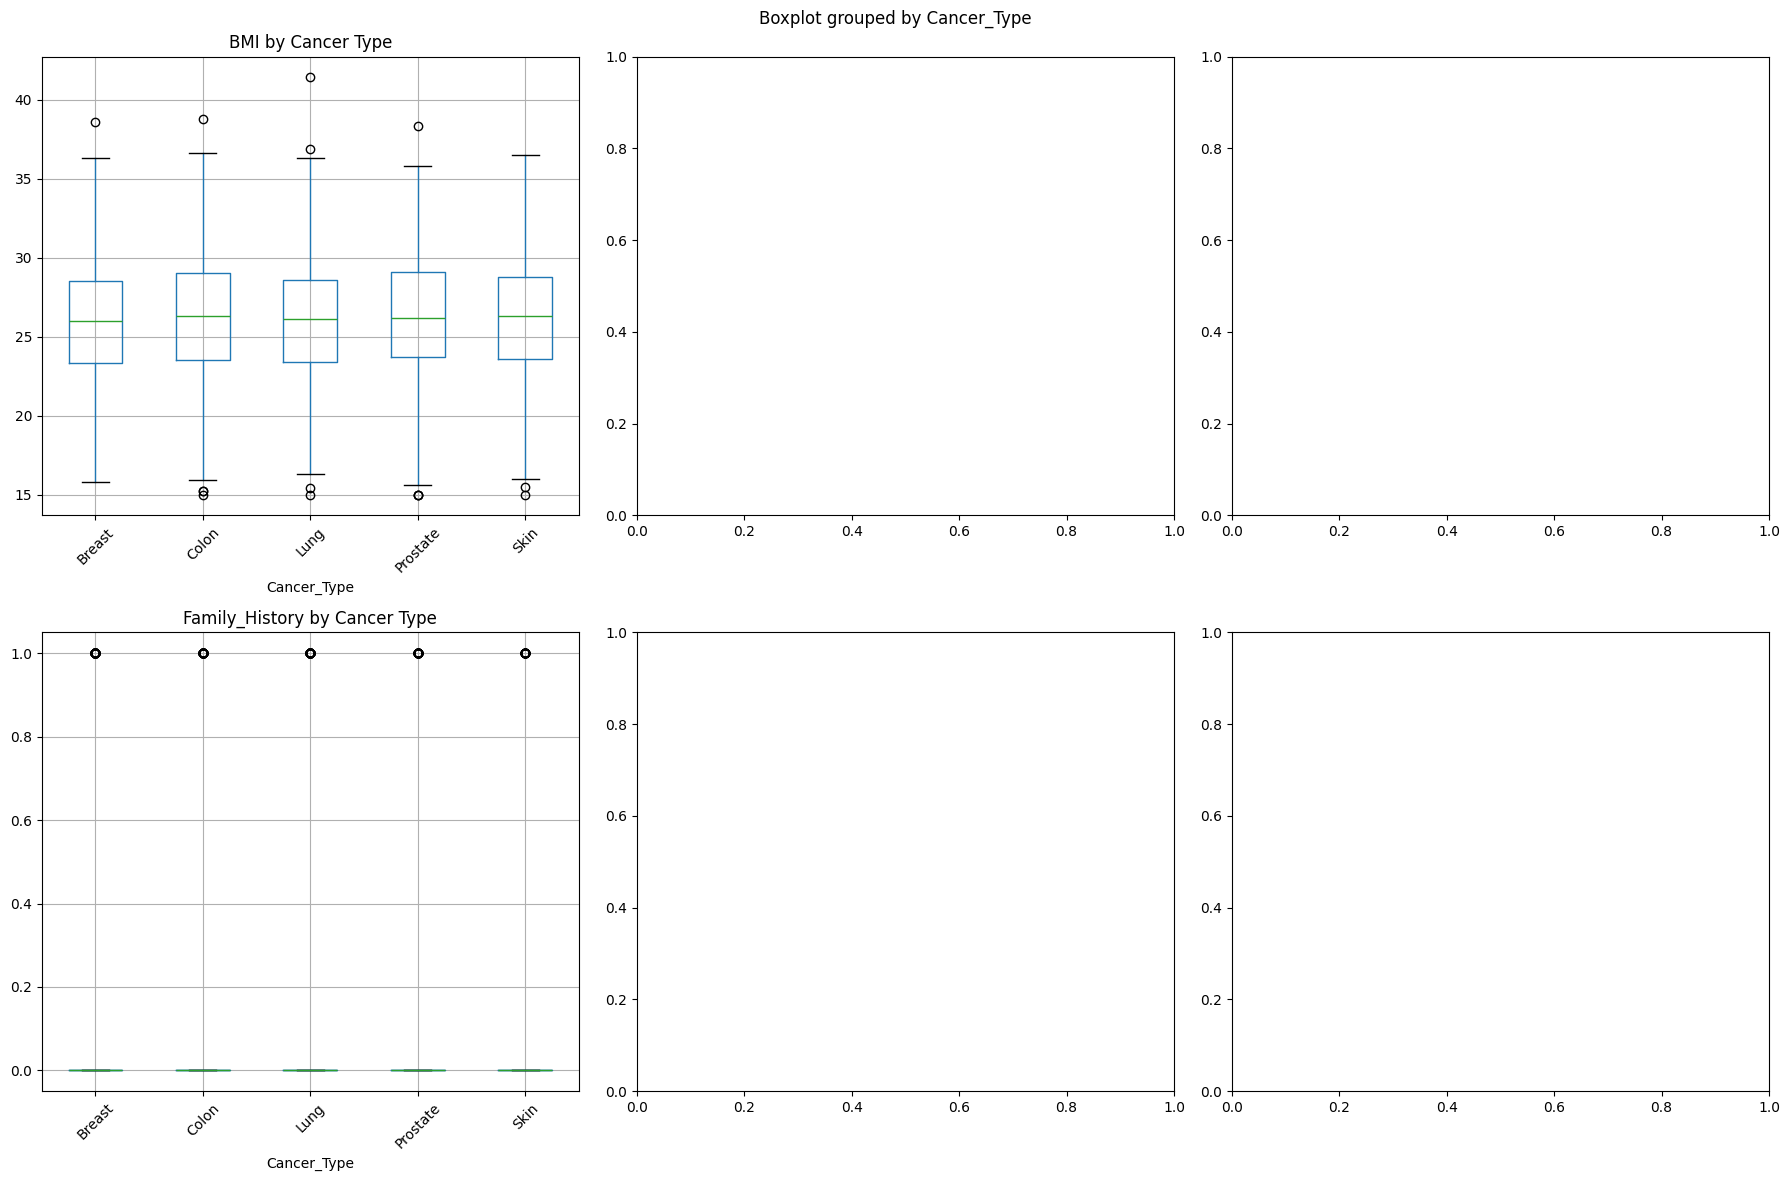

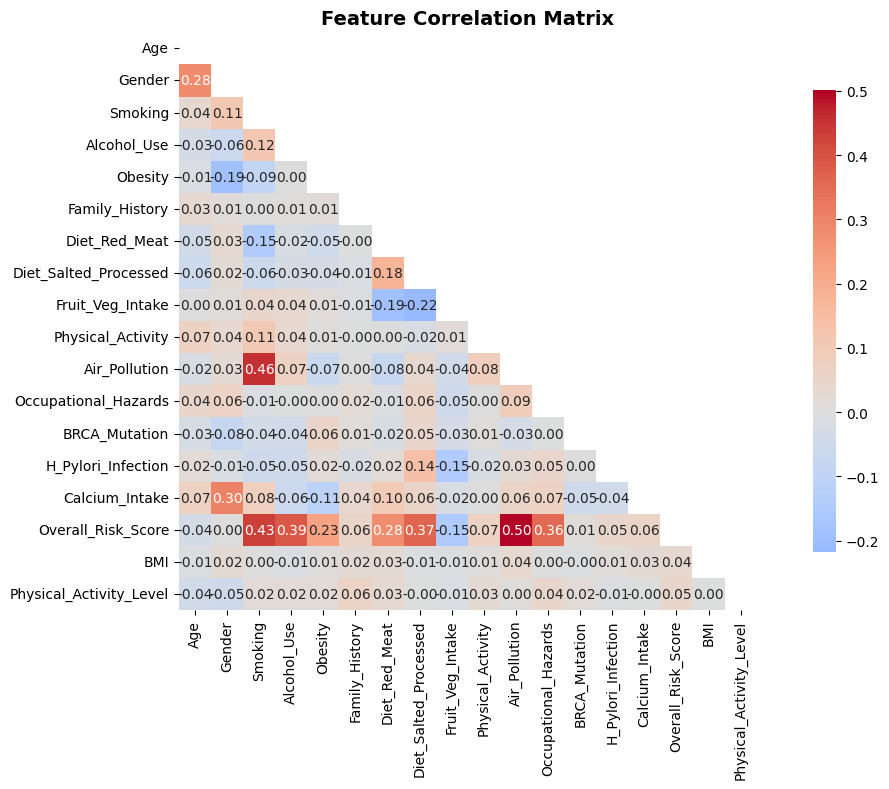

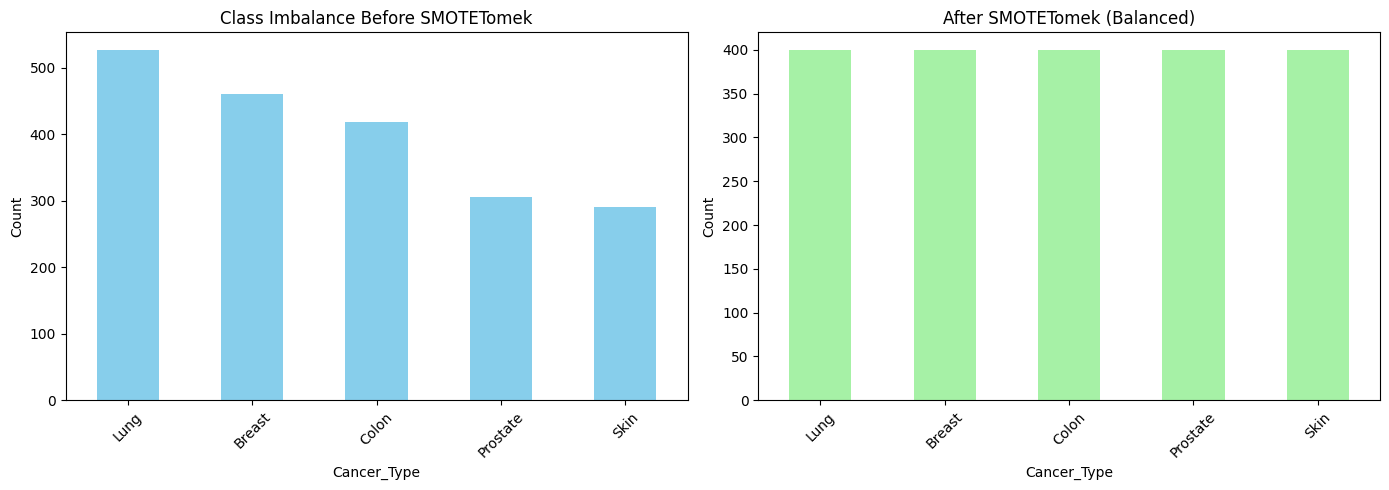

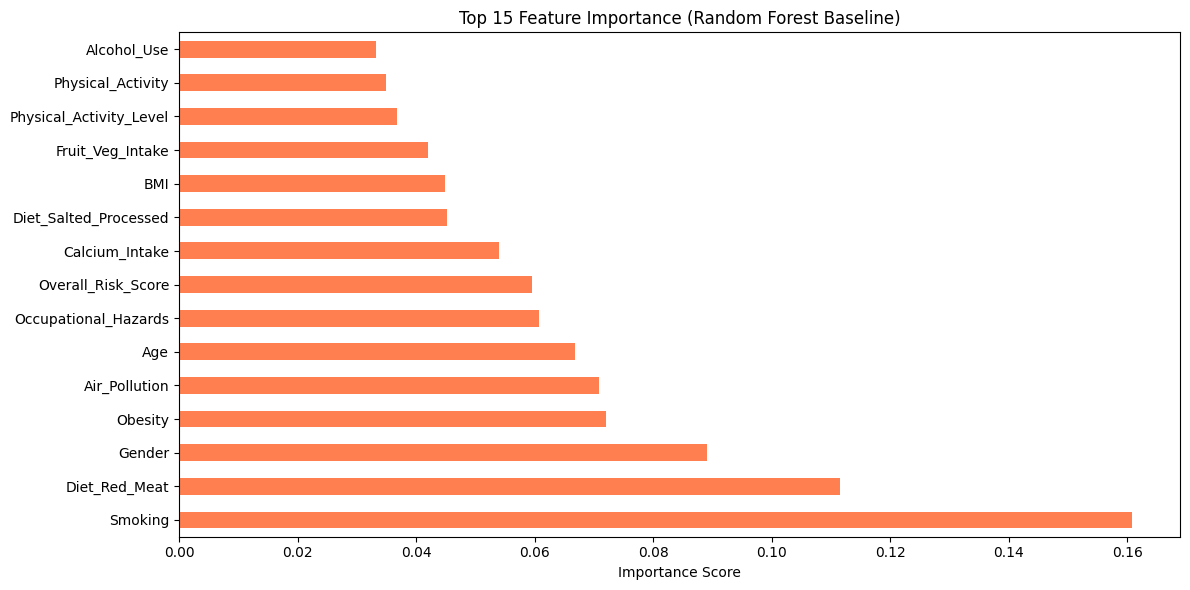

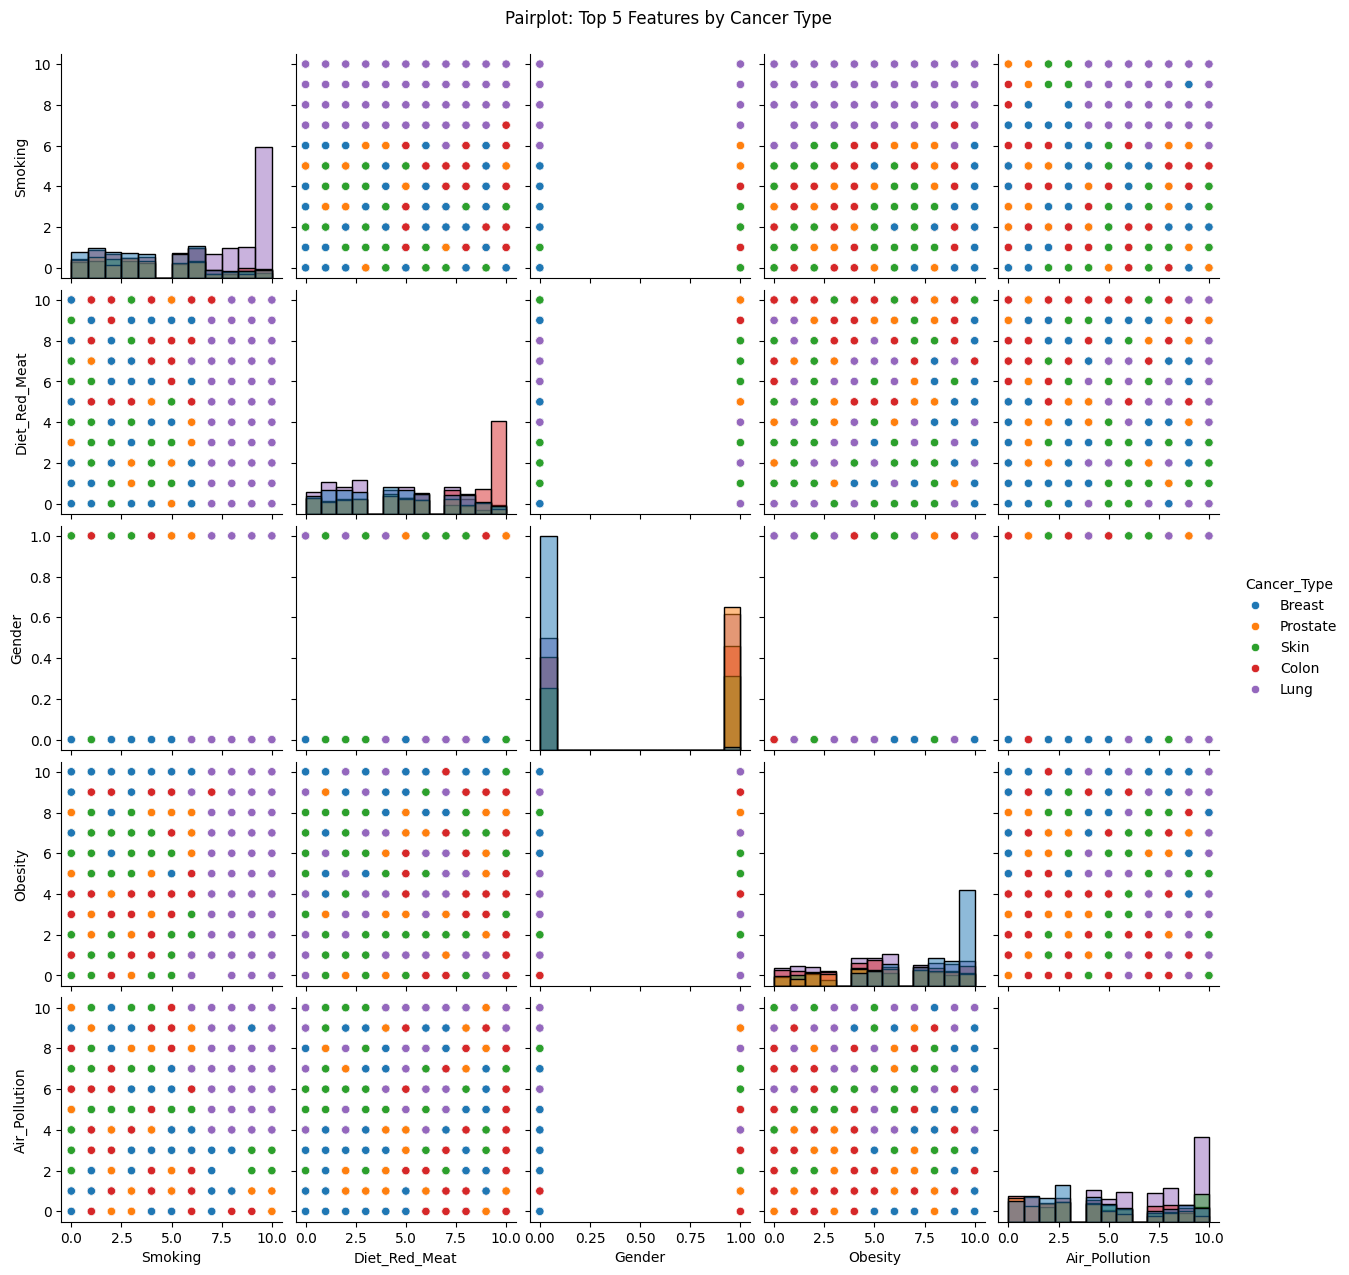


📊 Graphical Overview Complete!
Generated: Dataset Summary | Risk Factors | Correlation | Class Balance | Feature Importance | Pairplot


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv("/content/cancer-risk-factors.csv")
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())

# 1. BASIC OVERVIEW
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Dataset Overview - Cancer Risk Factors', fontsize=16, fontweight='bold')

# 1.1 Dataset Shape & Info
axes[0,0].axis('off')
axes[0,0].text(0.1, 0.8, f'Shape: {df.shape[0]} rows × {df.shape[1]} cols\n\n'
                     f'Missing: {df.isnull().sum().sum()} values\n'
                     f'Duplicates: {df.duplicated().sum()}\n'
                     f'Cancer Types: {df["Cancer_Type"].nunique()} types\n'
                     f'Categorical: {df.select_dtypes("object").shape[1]} cols\n'
                     f'Numeric: {df.select_dtypes("number").shape[1]} cols',
              fontsize=12, fontweight='bold')
axes[0,0].set_title('Dataset Summary', fontweight='bold')

# 1.2 Target Distribution
cancer_counts = df['Cancer_Type'].value_counts()
axes[0,1].pie(cancer_counts.values, labels=cancer_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Cancer Type Distribution')

# 1.3 Missing Values Heatmap
missing = df.isnull().sum()
axes[1,0].bar(range(len(missing)), missing.values, color='salmon')
axes[1,0].set_xticks(range(len(missing)))
axes[1,0].set_xticklabels(missing.index, rotation=90)
axes[1,0].set_title('Missing Values by Feature')

# 1.4 Numeric Features Distribution
numeric_cols = df.select_dtypes('number').columns
df[numeric_cols].hist(bins=30, figsize=(12, 8), ax=axes[1,1])
axes[1,1].set_title('Numeric Features Distribution')
plt.tight_layout()
plt.show()

# 2. RISK FACTOR ANALYSIS
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Key Risk Factor Analysis', fontsize=16, fontweight='bold')

# Key risk factors (adjust column names as per your dataset)
risk_cols = ['BMI', 'Smoking_Years', 'Alcohol_Consumption', 'Family_History', 'Age_Group']
for i, col in enumerate(risk_cols[:6]):
    if col in df.columns:
        row, col_idx = divmod(i, 3)
        if df[col].dtype == 'object':
            df[col].value_counts().plot(kind='bar', ax=axes[row, col_idx])
        else:
            df.boxplot(column=col, by='Cancer_Type', ax=axes[row, col_idx])
        axes[row, col_idx].set_title(f'{col} by Cancer Type')
        axes[row, col_idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 3. CORRELATION ANALYSIS
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 4. CLASS IMBALANCE VISUALIZATION
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
cancer_counts.plot(kind='bar', color='skyblue')
plt.title('Class Imbalance Before SMOTETomek')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
# Simulate SMOTETomek balance (after preprocessing)
balanced_counts = pd.Series([df['Cancer_Type'].value_counts().mean()] * df['Cancer_Type'].nunique(),
                           index=df['Cancer_Type'].value_counts().index)
balanced_counts.plot(kind='bar', color='lightgreen', alpha=0.8)
plt.title('After SMOTETomek (Balanced)')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 5. FEATURE IMPORTANCE (Random Forest Baseline)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Prepare data
le = LabelEncoder()
y_enc = le.fit_transform(df['Cancer_Type'])
X_num = df.select_dtypes(include=[np.number]).fillna(df.select_dtypes(include=[np.number]).median())

X_train, X_test, y_train, y_test = train_test_split(X_num, y_enc, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

plt.figure(figsize=(12, 6))
feat_imp = pd.Series(rf.feature_importances_, index=X_num.columns).sort_values(ascending=False)
feat_imp.head(15).plot(kind='barh', color='coral')
plt.title('Top 15 Feature Importance (Random Forest Baseline)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# 6. PAIRPLOT (Top 5 features by cancer type)
top_features = feat_imp.head(5).index.tolist()
sns.pairplot(df[top_features + ['Cancer_Type']], hue='Cancer_Type', diag_kind='hist')
plt.suptitle('Pairplot: Top 5 Features by Cancer Type', y=1.02)
plt.show()

print("\n📊 Graphical Overview Complete!")
print("Generated: Dataset Summary | Risk Factors | Correlation | Class Balance | Feature Importance | Pairplot")


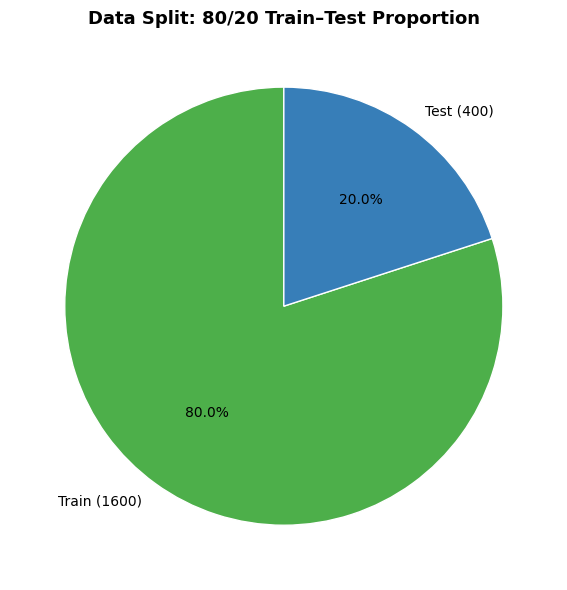

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv("/content/cancer-risk-factors.csv")

# Features/target (use your actual target column)
X = df.drop(columns=["Cancer_Type"])
y = df["Cancer_Type"]

# 80/20 split (same as in your model code)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Sizes
train_size = len(X_train)
test_size = len(X_test)

# Pie chart
sizes = [train_size, test_size]
labels = [f"Train ({train_size})", f"Test ({test_size})"]
colors = ["#4daf4a", "#377eb8"]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
        colors=colors, wedgeprops={'edgecolor': 'white'})
plt.title("Data Split: 80/20 Train–Test Proportion", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()
